In [1]:
#!pip install tqdm

In [2]:
#!pip install pandas

In [3]:
#!pip install nltk

In [4]:
#!pip install -U spacy

In [5]:
#!pip install es_core_news_sm

In [6]:
#!pip install scikit-learn

In [7]:
#!pip install matplotlib

In [8]:
#!pip install seaborn

In [9]:
#!pip install cltk

In [10]:
#!pip install scikit-plot

In [11]:
#!pip install imblearn

In [12]:
import os
os.chdir("/home/martinaleo/.ssh/authorship/pydro")

from src.dro import DistributionalRandomOversampling



In [13]:
# !ls /home/martinaleo/.ssh/authorship/pydro/src


# Imports

In [14]:
from tqdm.notebook import tqdm

from data_loader import load_spanish_corpus

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


import re

from nltk import download
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import spacy
import es_core_news_sm

from splitting__ import Segmentation

from helpers__ import get_function_words

from features import ( 
    FeaturesFunctionWords, 
    FeaturesDVEX, 
    FeaturesMendenhall, 
    FeaturesSentenceLength, 
    FeaturesPOST, 
    FeatureSetReductor,
    HstackFeatureSet
)


from sklearn.feature_selection import SelectKBest, chi2

from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    RandomizedSearchCV,
    GridSearchCV,
)

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)

from scikitplot.metrics import plot_roc

from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier

from imblearn.over_sampling import SMOTE


/home/martinaleo/.local/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'es_core_news_sm' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/home/martinaleo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Loading

In [15]:
documents, authors, filenames = load_spanish_corpus(path='/home/martinaleo/authorship/src/data/Corpus')

loading: /home/martinaleo/authorship/src/data/Corpus: 100%|██████████| 31/31 [00:00<00:00, 1180.71it/s]


In [16]:
print(filenames)

['Agustín de Rojas Villandrando - El viaje entretenido', 'Alonso de Castillo Solórzano - Aventuras del Bachiller Trapaza', 'Alonso de Castillo Solórzano - Las harpías en Madrid y coche de las estafas', 'Avellaneda - Quijote apocrifo', 'Cervantes - El amante liberal', 'Cervantes - El casamiento engañoso', 'Cervantes - El celoso extremeño', 'Cervantes - El coloquio de los perros', 'Cervantes - El licenciado Vidriera', 'Cervantes - La Gitanilla', 'Cervantes - La dos doncellas', 'Cervantes - La española inglesa', 'Cervantes - La fuerza de la sangre', 'Cervantes - La ilustre fregona', 'Cervantes - La señora Cornelia', 'Cervantes - Los trabajos de Persiles y Sigismunda', 'Cervantes - Rinconete y Cortadillo', 'Cristóbal Suárez de Figueroa - El pasajero', 'Guillén de Castro - El nacimiento de Montesinos', 'Guillén de Castro - Las mocedades del Cid', 'Juan Ruiz de Alarcón y Mendoza - La verdad sospechosa', 'Lope de Vega - Guzmán el Bravo', 'Lope de Vega - La desdicha por la honra', 'Lope de Veg

In [17]:
np.unique(authors, return_counts=True)

(array(['Agustín de Rojas Villandrando ', 'Alonso de Castillo Solórzano ',
        'Avellaneda ', 'Cervantes ', 'Cristóbal Suárez de Figueroa ',
        'Guillén de Castro ', 'Juan Ruiz de Alarcón y Mendoza ',
        'Lope de Vega ', 'Mateo Alemán ', 'Pasamonte ', 'Pérez de Hita ',
        'Quevedo ', 'Tirso de Molina '], dtype='<U31'),
 array([ 1,  2,  1, 13,  1,  2,  1,  4,  2,  1,  1,  1,  1]))

# Data Cleaning

### Noise elimination

In [18]:
documents = [document.lower() for document in documents]
documents = [(re.sub(r'\[(?:(?!\[|\]).)*\]', '', document)) for document in documents] 
# elimina le parti di testo delimitate da [] e che non contengono al loro interno ][

authors = [author.rstrip() for author in authors]

# Segmentation & Splitting

In [19]:
target = 'Cervantes'
y_labels =  (target, 'Other')

In [20]:
X = documents
y = [1 if author.rstrip() == target else 0 for author in authors]
# y_cat = [1 if author.rstrip() == target else 0 for author in authors]

positive_class = np.sum(y)
negative_class = len(y) - positive_class

print('Target class:', target)
print(f'Positive samples: {positive_class}')
print(f'Negative samples: {negative_class}')

Target class: Cervantes
Positive samples: 13
Negative samples: 18


In [21]:
def compute_n_tokens(filenames, documents):
    tokens_per_doc = sorted([(opus, sum(len(word_tokenize(sent)) for sent in sent_tokenize(doc))) for opus, doc in zip(filenames, documents)], key=lambda x: x[1], reverse=True)
    mean_tok = round(np.mean([n_tok for opus, n_tok in tokens_per_doc]), 2)
    median_tok = round(np.median([n_tok for opus, n_tok in tokens_per_doc]), 2)
    std_tok =  round(np.std([n_tok for opus, n_tok in tokens_per_doc]), 2)
    return tokens_per_doc, mean_tok, median_tok, std_tok

In [22]:
# tokens_per_doc,_,_,_ = compute_n_tokens([filename.split('-')[1].strip() for filename in filenames], documents)
# tokens_per_doc

In [23]:
# df_tok = pd.DataFrame(tokens_per_doc, columns=['Opus', 'Num of tokens'])

# plt.figure(figsize=(10, 6)) 
# sns.barplot(x='Opus', y='Num of tokens', data=df_tok, hue='Opus', dodge=False)  
# plt.xticks(rotation=60, ha="right")  
# plt.show()

In [24]:
# from nltk.tokenize import sent_tokenize

# sent_lenghts = [[len(word_tokenize(sent)) for sent in sent_tokenize(text)] for text in documents]

In [25]:
# mean_per_doc = 0
# mean_len_dict = dict()

# for i, sent_len_set in enumerate(sent_lenghts):
#     for sent_len in sent_len_set:
#         mean_per_doc +=sent_len
#     mean_per_doc = mean_per_doc/len(sent_len_set)
#     mean_len_dict[i+1]=mean_per_doc

In [26]:
# flat_lenghts = list()
# for row in sent_lenghts:
#     flat_lenghts.extend(row)
# [len_s for len_s in flat_lenghts if len_s > 300]

In [27]:
# plt.hist(flat_lenghts, bins=range(min(flat_lenghts), max(flat_lenghts) + 2), align='left', color='blue')
# plt.axvline(np.mean(flat_lenghts), color='red', linestyle='dashed', linewidth=1, label=f'Media = {round(np.mean(flat_lenghts),2)}')
# plt.axvline(np.median(flat_lenghts), color='black', linestyle='dashed', linewidth=1, label=f'Mediana = {round(np.median(flat_lenghts),2)}')
# plt.axvline(np.percentile(flat_lenghts,10), color='green', linestyle='dashed', linewidth=1.5, label=f'10th percentile = {round(np.percentile(flat_lenghts,10),2)}')
# plt.legend()
# plt.show()

In [28]:
X_dev, X_test, y_dev, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [29]:
positive_class_dev = np.sum(y_dev)
negative_class_dev = len(y_dev) - positive_class_dev
pos_ratio_dev = round(positive_class_dev / len(y_dev), 2)

positive_class_test = np.sum(y_test)
negative_class_test = len(y_test) - positive_class_test
pos_ratio_test = round(positive_class_test / len(y_test), 2)

tot_pos_ratio = (positive_class_dev + positive_class_test) / len(y)

print(f'Positive samples: {positive_class_dev}')
print(f'Negative samples: {negative_class_dev}')
print()
print(f'Positive samples: {positive_class_test}')
print(f'Negative samples: {negative_class_test}')

Positive samples: 9
Negative samples: 12

Positive samples: 4
Negative samples: 6


In [30]:
print('Positive samples ratio:', 
    '\nTrain:', pos_ratio_dev, 
    '\nTest:', pos_ratio_test, 
    '\nWhole dataset:',tot_pos_ratio)

Positive samples ratio: 
Train: 0.43 
Test: 0.4 
Whole dataset: 0.41935483870967744


In [31]:
from splitting__ import Segmentation
min_tokens = 500

segmentator_dev = Segmentation(split_policy='by_sentence', tokens_per_fragment=min_tokens)
splitted_docs_dev = segmentator_dev.fit_transform(documents=X_dev, authors=y_dev)
groups_dev = segmentator_dev.groups
# lista composta da due liste, una contenente le frasi, una contenente gli autori

generating fragments:   0%|          | 0/21 [00:00<?, ?it/s]

generating fragments: 100%|██████████| 21/21 [01:08<00:00,  3.27s/it]


In [32]:
len(groups_dev) # la segmentazione restituisce sia i documenti per intero che quelli frammentati

2406

In [33]:
segmentator_test = Segmentation(split_policy='by_sentence', tokens_per_fragment=min_tokens)
splitted_docs_test = segmentator_test.transform(documents=X_test, authors=y_test)
groups_test = segmentator_test.groups

generating fragments:   0%|          | 0/10 [00:00<?, ?it/s]

generating fragments: 100%|██████████| 10/10 [00:29<00:00,  2.93s/it]


In [34]:
# set per interi documenti
whole_docs_test = splitted_docs_test[0][:10]
whole_docs_y_test = splitted_docs_test[1][:10]
whole_docs_groups_test = groups_test[:10]

# set per documenti frammentati
fragmented_docs_test = splitted_docs_test[0][10:]
fragmented_docs_y_test = splitted_docs_test[1][10:]
fragmented_docs_groups_test = groups_test[10:]

In [35]:
print((len(splitted_docs_dev[0]), len(splitted_docs_dev[1]), len(groups_dev)),
(len(splitted_docs_test[0]), len(splitted_docs_test[1]), len(groups_test)))

(2406, 2406, 2406) (718, 718, 718)


In [36]:
np.unique(splitted_docs_dev[1], return_counts=True), np.unique(splitted_docs_test[1], return_counts=True)

((array([0, 1]), array([1814,  592])), (array([0, 1]), array([594, 124])))

In [37]:
dev_pos_class_ratio = np.sum(splitted_docs_dev[1]) / len(splitted_docs_dev[1])
test_pos_class_ratio = np.sum(splitted_docs_test[1]) / len(splitted_docs_test[1])
tot_pos_class_ratio = (np.sum(splitted_docs_dev[1]) + np.sum(splitted_docs_test[1])) / (len(splitted_docs_dev[1]) + len(splitted_docs_test[1]))

In [38]:
print('Positive samples ratio:', 
      '\nTrain:', dev_pos_class_ratio, 
      '\nTest:', test_pos_class_ratio,
      '\nWhole dataset:', tot_pos_class_ratio)

Positive samples ratio: 
Train: 0.2460515378221114 
Test: 0.17270194986072424 
Whole dataset: 0.22919334186939821


In [39]:
X_dev = splitted_docs_dev[0]
y_dev = splitted_docs_dev[1]
groups_dev = segmentator_dev.groups

X_test = whole_docs_test
y_test = whole_docs_y_test
groups_test = whole_docs_groups_test

X_test_frag = fragmented_docs_test
y_test_frag = fragmented_docs_y_test
groups_test_frag = fragmented_docs_groups_test
#y__ = list(zip(splitted_docs[1], groups))

len(X_dev), len(y_dev), len(groups_dev),len(X_test), len(y_test), len(groups_test)

(2406, 2406, 2406, 10, 10, 10)

# Data Preparation

In [40]:
fuction_ws = get_function_words(lang='spanish')

In [41]:
# vectorizers
function_words_extractor = FeaturesFunctionWords(language='spanish')
mendenhall_extractor = FeaturesMendenhall(upto=20)
words_masker = FeaturesDVEX(function_words=fuction_ws)
sentence_len_extractor = FeaturesSentenceLength()
POS_extractor = FeaturesPOST(language='spanish')

loading cache from .postcache/dict.pkl


In [42]:
len(X_dev), len(y_dev)

(2406, 2406)

In [43]:
%%time
fw_reductor = FeatureSetReductor(function_words_extractor) 
fw_red = fw_reductor.fit_transform(X_dev, authors=y_dev)
fw_red_test = fw_reductor.transform(X_test)

sl_reductor = FeatureSetReductor(sentence_len_extractor) 
sl_red = sl_reductor.fit_transform(documents=X_dev, authors=y_dev)
sl_red_test = sl_reductor.transform(X_test)

me_reductor = FeatureSetReductor(mendenhall_extractor)
me_red = me_reductor.fit_transform(X_dev, authors=y_dev)
me_red_test = me_reductor.transform(X_test)

wm_reductor = FeatureSetReductor(words_masker)
wm_red = wm_reductor.fit_transform(X_dev, authors=y_dev)
wm_red_test = wm_reductor.transform(X_test)

pos_reductor = FeatureSetReductor(POS_extractor)
pos_red = pos_reductor.fit_transform(X_dev, authors=y_dev)
pos_red_test = pos_reductor.transform(X_test)


FeatureSetReductor for FeaturesFunctionWords
features in: 313 k: 156

FeatureSetReductor for FeaturesSentenceLength
features in: 998 k: 499

FeatureSetReductor for FeaturesMendenhall
features in: 18 k: 18

FeatureSetReductor for FeaturesDVEX
features in: 387 k: 194

FeatureSetReductor for FeaturesPOST
features in: 9 k: 9

CPU times: user 2min 15s, sys: 828 ms, total: 2min 16s
Wall time: 2min 15s


In [44]:
%%time
fw_red_test_fragments = fw_reductor.transform(X_test_frag)
sl_red_test_fragments = sl_reductor.transform(X_test_frag)
me_red_test_fragments = me_reductor.transform(X_test_frag)
wm_red_test_fragments = wm_reductor.transform(X_test_frag)
pos_red_test_fragments = pos_reductor.transform(X_test_frag)

CPU times: user 10.7 s, sys: 0 ns, total: 10.7 s
Wall time: 10.7 s


In [45]:
# from sklearn.preprocessing import Normalizer # new!

# def l2_normalize(features, features_test):
#     normalizer = Normalizer()
#     features_norm = normalizer.fit_transform(features)
#     features_norm_test = normalizer.transform(features_test)
#     return features_norm, features_norm_test

In [46]:
# fw_norm, fw_norm_test = l2_normalize(fw_red, fw_red_test)
# me_norm, me_norm_test = l2_normalize(me_red, me_red_test)
# wm_norm, wm_norm_test = l2_normalize(wm_red, wm_red_test)
# pos_norm, pos_norm_test = l2_normalize(pos_red, pos_red_test)

In [47]:
hstacker = HstackFeatureSet(function_words_extractor, words_masker, mendenhall_extractor, POS_extractor, sentence_len_extractor)
hstacked_features = hstacker._hstack([fw_red, me_red, wm_red, pos_red, sl_red])
# #hstacked_features = hstacker._hstack([fw_norm, me_norm, wm_norm, pos_norm])

In [48]:
hstacked_features_test = hstacker._hstack([fw_red_test, me_red_test, wm_red_test, pos_red_test, sl_red_test])
#hstacked_features_test = hstacker._hstack([fw_norm_test, me_norm_test, wm_norm_test, pos_norm_test])

In [49]:
hstacked_features_test_frag = hstacker._hstack([fw_red_test_fragments, me_red_test_fragments, wm_red_test_fragments, pos_red_test_fragments, sl_red_test_fragments])

# Model Building

In [50]:
def build_model(X_dev, y_dev, groups, X_test, model=None, print_scores=True, param_grid=None, pipe=False, feature_extractor=None, return_proba=True):
    
    n_folds = 5

    if not model:
        clf = LinearSVC(random_state=42, class_weight='balanced', max_iter=10000)
        clf = CalibratedClassifierCV(clf) if return_proba else clf
        
    if param_grid:
        if not pipe:
            pipe = Pipeline([('learner', clf)])
        else:
            pipe = Pipeline([
                ('sel', SelectKBest(chi2)),
                ('learner', clf)  # learning algorithm
                ])

        grid = GridSearchCV(
            pipe,
            param_grid=param_grid,
            cv=n_folds,
            n_jobs=-1,
            scoring='f1_weighted')
        grid.fit(X_dev, y_dev, groups=groups)
        clf = grid.best_estimator_
        
    if return_proba:
        y_proba_dev = clf.predict_proba(X_dev)[:, 1] # posterior probabilities training set
        y_proba_test = clf.predict_proba(X_test)[:, 1] # posterior probabilities test set
          
    y_pred = clf.predict(X_test)

    if print_scores:
        if not param_grid:
            scores = cross_val_score(clf, X_dev, y_dev, cv=n_folds, groups=groups)
            print(feature_extractor)
            print('Accuracy score:',scores.mean(), 'Std:', scores.std())
            print()
        else:
            print(feature_extractor)
            print('Best estimator:', grid.best_estimator_, '\nBest score:',grid.best_score_)
            print()
    return clf, y_pred, grid.best_score_, y_proba_dev, y_proba_test


In [51]:
def ensemble(predictions, y_test, threshold=0.5, majority_vote=False):
    if majority_vote:
        y_pred_ensemble = np.sum(predictions, axis=0)/len(predictions)
        y_pred_ensemble = [1 if pred >= threshold else 0 for pred in y_pred_ensemble]
        weighted_f1 = f1_score(y_pred_ensemble, y_test, average='weighted')

    else:
        f1_scores = {f1_score(y_test, y_pred, average='weighted'):y_pred for y_pred in predictions}
        weighted_preds = [[score*pred for pred in preds] for score,preds in f1_scores.items()] # pesa ogni predizione in base all'f1 score del classificatore
        y_pred_ensemble = np.sum(weighted_preds, axis=0)/len(predictions) # per ogni predizione pesata per ogni istanza, somma le predizioni e le divide per il numero di classificatori
        #y_pred_ensemble = [round(pred) for pred in y_pred_ensemble]
        y_pred_ensemble = [1 if pred >= threshold else 0 for pred in y_pred_ensemble] # binarizza output
        weighted_f1 = f1_score(y_pred_ensemble, y_test, average='weighted')

    return y_pred_ensemble, weighted_f1


def ensamble_prob(probabilities, y_test, threshold=0.5):
    probs_sum = np.sum(probabilities, axis=0)/len(probabilities)
    #f1_score(y_test,[1 if prob > 0.2 else 0 for prob in probs_sum])
    class_report= classification_report(y_test,[1 if prob >= threshold else 0 for prob in probs_sum])
    y_pred=[1 if prob >= threshold else 0 for prob in probs_sum]
    weighted_f1 = f1_score(y_pred, y_test, average='weighted')
    return class_report, y_pred, weighted_f1


def ensamble_prob_weighted(probabilities, y_test, single_threshold=0.5, threshold=0.5):
    predictions=[[1 if prob >= single_threshold else 0 for prob in prob_set] for prob_set in probabilities]
    f1_scores = {f1_score(y_test, prob_set, average='weighted', zero_division=np.nan):prob_set for prob_set in predictions}
    weighted_probs = [[prob*f1 for prob in prob_set] for f1,prob_set in f1_scores.items()]
    probs_sum = np.sum(weighted_probs, axis=0)/len(weighted_probs)
    #f1_score(y_test,[1 if prob > 0.2 else 0 for prob in probs_sum])
    class_report= classification_report(y_test,[1 if prob >= threshold else 0 for prob in probs_sum])
    y_pred=[1 if prob >= threshold else 0 for prob in probs_sum]
    weighted_f1 = f1_score(y_pred, y_test, average='weighted')
    return class_report, y_pred, weighted_f1

In [52]:
def fit_base_clf(clf, X_dev, y_dev, X_test_tot, groups, fun_kfcv=False):
    
    # clf = CalibratedClassifierCV(clf)
    
    if fun_kfcv:
        num_folds = 5
        stratkf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
        y_proba_dev_pos = np.zeros_like(y_dev)
        y_proba_dev_neg = np.zeros_like(y_dev)
        y_proba_test_fold_pos = list()
        y_proba_test_fold_neg = list()
        y_dev_np = np.array(y_dev)

        for train_index, test_index in stratkf.split(X_dev, y_dev_np, groups=groups):
            X_train, X_test = X_dev[train_index], X_dev[test_index]
            y_train, y_test = y_dev_np[train_index], y_dev_np[test_index]

            clf_fold = CalibratedClassifierCV(clf)
            
            clf_fold.fit(X_train, y_train)
            y_proba_dev_pos[test_index] = clf_fold.predict_proba(X_test)[:, 1]
            y_proba_dev_neg[test_index] = clf_fold.predict_proba(X_test)[:, 0]
            y_proba_test_fold_pos.append(clf_fold.predict_proba(X_test_tot)[:, 1])
            y_proba_test_fold_neg.append(clf_fold.predict_proba(X_test_tot)[:, 0])
            
        #y_proba_test = clf.predict_proba(X_test_tot)[:, 1]
        y_proba_test_pos= np.sum(y_proba_test_fold_pos, axis=0)/num_folds
        y_proba_test_neg= np.sum(y_proba_test_fold_neg, axis=0)/num_folds

        y_proba_dev = np.column_stack([y_proba_dev_pos, y_proba_dev_neg])
        y_proba_test= np.column_stack([y_proba_test_pos, y_proba_test_neg])

            
    else: 
        # Fun tat
        clf = CalibratedClassifierCV(clf)
        clf.fit(X_dev, y_dev)
        y_proba_dev_pos = clf.predict_proba(X_dev)[:, 1]
        y_proba_dev_neg = clf.predict_proba(X_dev)[:, 0]
        y_proba_test_pos = clf.predict_proba(X_test_tot)[:, 1]
        y_proba_test_neg = clf.predict_proba(X_test_tot)[:, 0]
        y_proba_dev = np.column_stack([y_proba_dev_pos, y_proba_dev_neg])
        y_proba_test = np.column_stack([y_proba_test_pos, y_proba_test_neg])
                                             

        #y_pred_dev = clf.predict(X_dev)
        

    return y_proba_dev, y_proba_test

In [53]:
def stacking_classification(final_estimator, posterior_proba_dev, y_dev, param_grid, groups):
    
    if not final_estimator:
        final_estimator = SVC(class_weight='balanced', random_state=42)

    # stacked_clf = StackingClassifier(
    #     estimators=estimators,
    #     final_estimator=final_estimator,
    #     n_jobs=-1,
    #     cv='prefit'
    # )
    grid = GridSearchCV(
            final_estimator,
            param_grid=param_grid,
            cv=5,
            n_jobs=-1,
            scoring='f1_weighted')
    
    grid.fit(posterior_proba_dev, y_dev, groups=groups)

    clf = grid.best_estimator_
    print(clf, grid.best_score_)
    return clf

## Ensemble & Hyperparameter search

In [54]:
res_df = pd.DataFrame(columns=['Grid', 'Ensemble', 'Stacked', 'Pipeline', 'With_proba','Weighted', 'Whole_docs', 'F1_weighted'])
idx_res=0

### whole docs

In [55]:
param_grid= {'learner__estimator__C': [0.1, 1, 10, 100],
             'learner__estimator__dual': ['auto'],
             'learner__estimator__random_state': [0]}

fw_clf, fw_pred, fw_score, fw_yproba_dev,fw_yproba_test = build_model(feature_extractor=fw_reductor, X_dev=fw_red, y_dev=y_dev, groups=groups_dev, X_test=fw_red_test,param_grid=param_grid)
me_clf, me_pred, me_score, me_yproba_dev, me_yproba_test = build_model(feature_extractor=me_reductor, X_dev=me_red, y_dev=y_dev, groups=groups_dev, X_test=me_red_test,param_grid=param_grid)
wm_clf, wm_pred, wm_score, wm_yproba_dev, wm_yproba_test = build_model(feature_extractor=wm_reductor, X_dev=wm_red, y_dev=y_dev, groups=groups_dev, X_test=wm_red_test,param_grid=param_grid)
pos_clf, pos_pred, pos_score, pos_yproba_dev, pos_yproba_test = build_model(feature_extractor=pos_reductor, X_dev=pos_red, y_dev=y_dev, groups=groups_dev, X_test=pos_red_test,param_grid=param_grid)
sl_clf, sl_pred, sl_score, sl_yproba_dev, sl_yproba_test = build_model(feature_extractor=sl_reductor, X_dev=sl_red, y_dev=y_dev, groups=groups_dev, X_test=sl_red_test,param_grid=param_grid)

FeatureSetReductor for FeaturesFunctionWords
Best estimator: Pipeline(steps=[('learner',
                 CalibratedClassifierCV(estimator=LinearSVC(C=10,
                                                            class_weight='balanced',
                                                            dual='auto',
                                                            max_iter=10000,
                                                            random_state=0)))]) 
Best score: 0.7920410717040383

FeatureSetReductor for FeaturesMendenhall
Best estimator: Pipeline(steps=[('learner',
                 CalibratedClassifierCV(estimator=LinearSVC(C=100,
                                                            class_weight='balanced',
                                                            dual='auto',
                                                            max_iter=10000,
                                                            random_state=0)))]) 
Best score: 0.6633749101903936

#### stacking classifier - fun(tat)

In [56]:
base_clfs = [LinearSVC(random_state=42, class_weight='balanced', max_iter=10000, dual='auto') for i in range(5)]
feature_spaces = [fw_red,sl_red,me_red,wm_red,pos_red]
feature_spaces_test = [fw_red_test,sl_red_test,me_red_test,wm_red_test,pos_red_test]
posterior_probs = [fit_base_clf(clf, feature_spaces[i], y_dev,feature_spaces_test[i], groups=groups_dev) for i, clf in enumerate(base_clfs)]
#clf_names= ['fw_clf','sl_clf','me_clf','wm_clf','pos_clf' ]
#estimators = [(clf_names[i], fitted_clf) for i, (fitted_clf,_,_) in enumerate(posterior_probs)]
probs_unstacked_dev = [proba for proba,_ in posterior_probs]
probs_unstacked_test = [proba for _, proba in posterior_probs]
posterior_probs_dev = np.column_stack([prob for prob in probs_unstacked_dev])
posterior_probs_test = np.column_stack([prob for prob in probs_unstacked_test])
final_estimator = SVC(class_weight='balanced', random_state=42)

param_grid = [{
    'kernel': ['rbf', 'sigmoid'],
    'C' : [0.1, 1, 10, 100],
    'gamma' : [0.0001, 0.001, 0.1, 1, 'scale', 'auto']
},
{
    'kernel' : ['poly'],
    'C' : [0.1, 1, 10, 100],
    'degree': [1, 2, 3, 4, 5],
    'gamma' : [0.0001, 0.001, 0.1, 1, 'scale', 'auto']
}]

stacking_classifier = stacking_classification(final_estimator, posterior_probs_dev, y_dev, param_grid, groups_dev)

SVC(C=100, class_weight='balanced', degree=1, gamma=1, kernel='poly',
    random_state=42) 0.8811135933333446


In [57]:
#posterior_probs_test = np.column_stack([fw_yproba_test,sl_yproba_test,me_yproba_test,wm_yproba_test,pos_yproba_test])
#posterior_probs_test = np.column_stack(probs for probs in posterior_probs_test_)
clf = stacking_classifier
#clf.fit(posterior_probs_dev, y_dev)
y_pred = clf.predict(posterior_probs_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print('Results on whole documents:') 
print('Accuracy (on whole documents):', acc) 
print('Weighted f1:',f1)
print()

Results on whole documents:
Accuracy (on whole documents): 1.0
Weighted f1: 1.0



In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [59]:
res_df.loc[idx_res] = {'Grid':0,
                'Ensemble': 1,
                'Stacked': 1,
                'Pipeline': 0, 
                'With_proba': 0,
                'Weighted': 0, 
                'Whole_docs': 1,
                'F1_weighted': round(f1, 2)
}
idx_res+=1
res_df.shape

(1, 8)

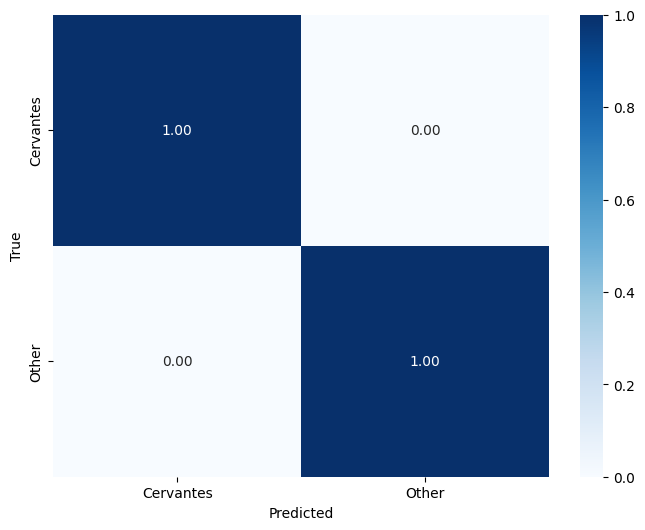

In [60]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#### stacking classifier - fun(kfcv)

In [61]:
base_clfs = [LinearSVC(random_state=42, class_weight='balanced', max_iter=10000, dual='auto') for i in range(5)]
feature_spaces = [fw_red,sl_red,me_red,wm_red,pos_red]
feature_spaces_test = [fw_red_test,sl_red_test,me_red_test,wm_red_test,pos_red_test]
posterior_probs = [fit_base_clf(clf, feature_spaces[i], y_dev,feature_spaces_test[i], groups=groups_dev, fun_kfcv=True) for i, clf in enumerate(base_clfs)]
#clf_names= ['fw_clf','sl_clf','me_clf','wm_clf','pos_clf' ]
#estimators = [(clf_names[i], fitted_clf.estimator) for i, (fitted_clf,_,_) in enumerate(fitted_clfs)]
probs_unstacked_dev = [dev_proba for dev_proba, _ in posterior_probs]
probs_unstacked_test = [test_proba for _, test_proba in posterior_probs]
posterior_probs_dev = np.column_stack([prob for prob in probs_unstacked_dev])
posterior_probs_test = np.column_stack([prob for prob in probs_unstacked_test])
final_estimator = SVC(class_weight='balanced', random_state=42)

param_grid = [{
    'kernel': ['rbf', 'sigmoid'],
    'C' : [0.1, 1, 10, 100],
    'gamma' : [0.0001, 0.001, 0.1, 1, 'scale', 'auto']
},
{
    'kernel' : ['poly'],
    'C' : [0.1, 1, 10, 100],
    'degree': [1, 2, 3, 4, 5],
    'gamma' : [0.0001, 0.001, 0.1, 1, 'scale', 'auto']
}]

stacking_classifier = stacking_classification(final_estimator, posterior_probs_dev, y_dev, param_grid, groups_dev)

SVC(C=100, class_weight='balanced', gamma=0.0001, random_state=42) 0.538537220916023


In [62]:
clf = stacking_classifier
clf.fit(posterior_probs_dev, y_dev)
y_pred = clf.predict(posterior_probs_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print('Results on whole documents:') 
print('Accuracy (on whole documents):', acc) 
print('Weighted f1:',f1)
print()

Results on whole documents:
Accuracy (on whole documents): 0.4
Weighted f1: 0.2285714285714286



In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.40      1.00      0.57         4

    accuracy                           0.40        10
   macro avg       0.20      0.50      0.29        10
weighted avg       0.16      0.40      0.23        10



/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### stacking classifier with optimized base classifiers

In [64]:
# final_estimator = SVC(class_weight='balanced', random_state=42)
# posterior_probs_dev = np.column_stack([fw_yproba_dev,sl_yproba_dev,me_yproba_dev,wm_yproba_dev,pos_yproba_dev])
# posterior_probs_test = np.column_stack([fw_yproba_test,sl_yproba_test,me_yproba_test,wm_yproba_test,pos_yproba_test])

estimators = [fw_clf,sl_clf,me_clf,wm_clf,pos_clf]
posterior_probs = [fit_base_clf(clf, feature_spaces[i], y_dev,feature_spaces_test[i], groups=groups_dev) for i, clf in enumerate(estimators)]
probs_unstacked_dev = [dev_proba for dev_proba, _ in posterior_probs]
probs_unstacked_test = [test_proba for _, test_proba in posterior_probs]
posterior_probs_dev = np.column_stack([prob for prob in probs_unstacked_dev])
posterior_probs_test = np.column_stack([prob for prob in probs_unstacked_test])
final_estimator = SVC(class_weight='balanced', random_state=42)

param_grid = [
   {
    'kernel': ['rbf', 'sigmoid'],
    'C' : [0.1, 1, 10, 100],
    'gamma' : [0.0001, 0.001, 0.1, 1, 'scale', 'auto']
},
{
    'kernel' : ['poly'],
    'C' : [0.1, 1, 10, 100],
    'degree': [1, 2, 3, 4, 5],
    'gamma' : [0.0001, 0.001, 0.1, 1, 'scale', 'auto']
}]

stacking_classifier = stacking_classification(final_estimator, posterior_probs_dev, y_dev, param_grid, groups_dev)


SVC(C=0.1, class_weight='balanced', degree=2, gamma=0.1, kernel='poly',
    random_state=42) 0.890731005885294


In [65]:
clf = stacking_classifier
y_pred = clf.predict(posterior_probs_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print('Results on whole documents:') 
print('Accuracy (on whole documents):', acc) 
print('Weighted f1:',f1)
print()

Results on whole documents:
Accuracy (on whole documents): 1.0
Weighted f1: 1.0



In [66]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [67]:
res_df.loc[idx_res] = {'Grid':1,
                'Ensemble': 1,
                'Stacked': 1,
                'Pipeline': 0, 
                'With_proba': 0,
                'Weighted': 0, 
                'Whole_docs': 1,
                'F1_weighted': round(f1, 2)
}
idx_res+=1
res_df.shape

(2, 8)

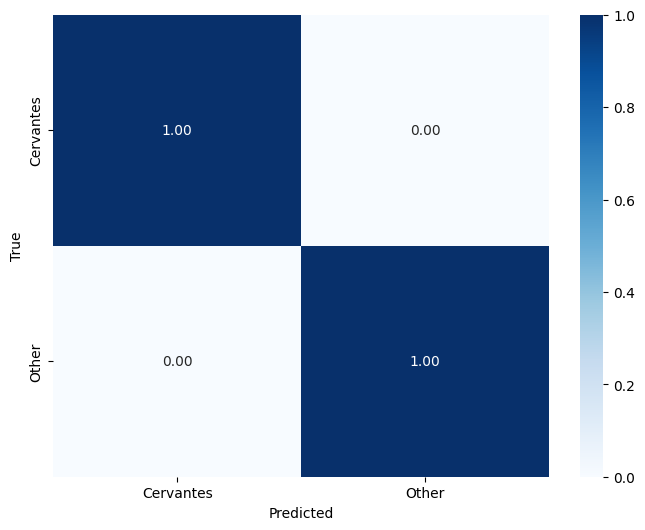

In [68]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#### with majority vote

In [69]:
for i in np.arange(0.1, 1, 0.1):
    ensemble_preds, f1_score_ensemble = ensemble(predictions=[fw_pred, sl_pred, me_pred, wm_pred, pos_pred], 
                                             y_test=y_test, majority_vote=True, threshold=0.5)
    print('threshold:', round(i,2), f1_score_ensemble)

threshold: 0.1 0.819047619047619
threshold: 0.2 0.819047619047619
threshold: 0.3 0.819047619047619
threshold: 0.4 0.819047619047619
threshold: 0.5 0.819047619047619
threshold: 0.6 0.819047619047619
threshold: 0.7 0.819047619047619
threshold: 0.8 0.819047619047619
threshold: 0.9 0.819047619047619


In [70]:
ensemble_preds, f1_score_ensemble = ensemble(predictions=[fw_pred, sl_pred, me_pred, wm_pred, pos_pred], 
                                             y_test=y_test, majority_vote=True, threshold=0.5) 
                                            
print(classification_report(y_test, ensemble_preds))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.50      0.67         4

    accuracy                           0.80        10
   macro avg       0.88      0.75      0.76        10
weighted avg       0.85      0.80      0.78        10



In [71]:
res_df.loc[idx_res] = {'Grid':1,
                'Ensemble': 1,
                'Stacked': 0,
                'Pipeline': 0, 
                'With_proba': 0,
                'Weighted': 0, 
                'Whole_docs': 1,
                'F1_weighted': round(f1_score_ensemble, 2)
}
idx_res+=1
res_df.shape

(3, 8)

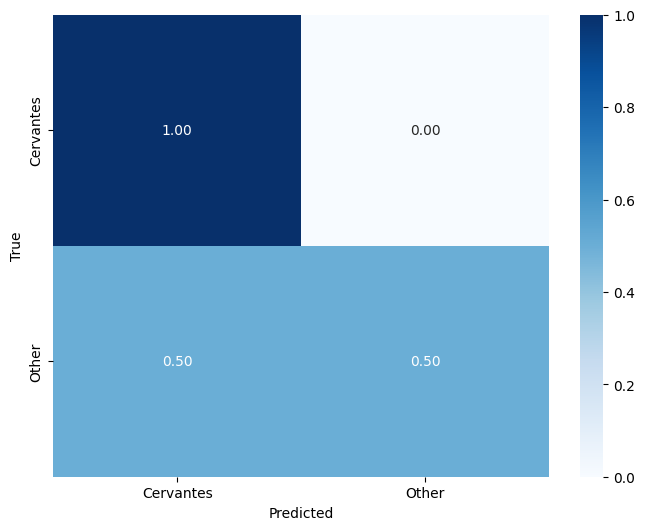

In [72]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test, ensemble_preds, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

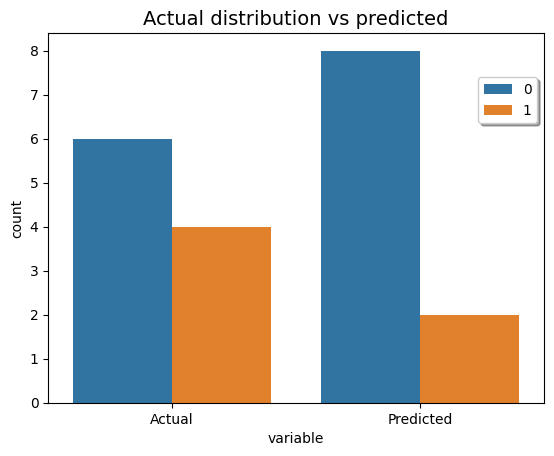

In [73]:
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': ensemble_preds})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

#### with weighting

In [74]:
for i in np.arange(0.1, 1, 0.1):
    ensemble_preds, f1_score_ensemble = ensemble(predictions=[fw_pred, sl_pred, me_pred, wm_pred, pos_pred],
                                                  y_test=y_test, threshold=i)
    print('threshold:', round(i,2), f1_score_ensemble)

threshold: 0.1 0.8
threshold: 0.2 0.819047619047619
threshold: 0.3 0.819047619047619
threshold: 0.4 0.7499999999999999
threshold: 0.5 0.7499999999999999
threshold: 0.6 0.7499999999999999
threshold: 0.7 0.7499999999999999
threshold: 0.8 0.7499999999999999
threshold: 0.9 0.7499999999999999


In [75]:
ensemble_preds, f1_score_ensemble = ensemble(predictions=[fw_pred, sl_pred, me_pred, wm_pred, pos_pred], y_test=y_test, threshold=0.3)
 # ma stesso risultato anche con numeri molto più piccoli
print(classification_report(y_test, ensemble_preds))

#0.8265445631350135

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.50      0.67         4

    accuracy                           0.80        10
   macro avg       0.88      0.75      0.76        10
weighted avg       0.85      0.80      0.78        10



In [76]:
res_df.loc[idx_res] = {'Grid':1,
                'Ensemble': 1,
                'Stacked': 0,
                'Pipeline': 0, 
                'With_proba': 0,
                'Weighted': 1, 
                'Whole_docs': 1,
                'F1_weighted': round(f1_score_ensemble, 2)
}
idx_res+=1
res_df.shape

(4, 8)

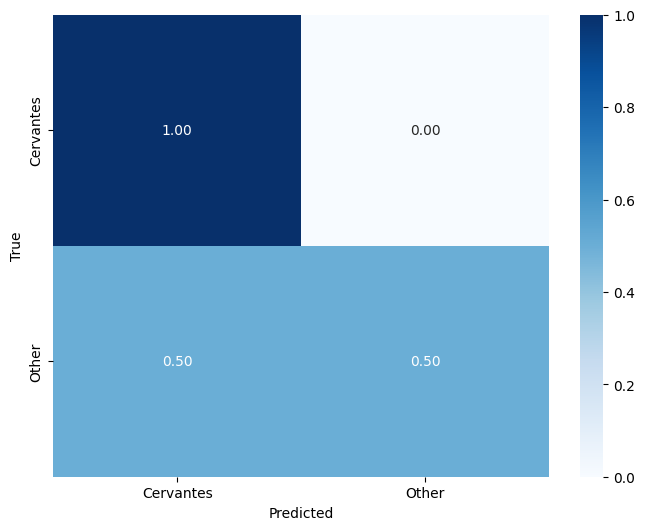

In [77]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test, ensemble_preds, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

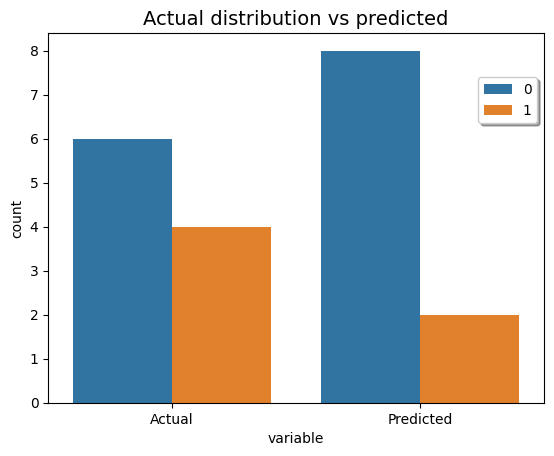

In [78]:
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': ensemble_preds})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

#### with probability

In [79]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

In [80]:
probs = [fw_yproba_test,sl_yproba_test,me_yproba_test,wm_yproba_test,pos_yproba_test]
for i in np.arange(0.1, 1, 0.1):
    class_report, y_pred,f1_score_ensemble =  ensamble_prob(probs, y_test, threshold=i) #267
    print('threshold:', round(i,2), f1_score_ensemble)

threshold: 0.1 0.5714285714285715
threshold: 0.2 0.898989898989899
threshold: 0.3 1.0
threshold: 0.4 0.9032967032967033
threshold: 0.5 0.7499999999999999
threshold: 0.6 0.7499999999999999
threshold: 0.7 0.7499999999999999
threshold: 0.8 0.7499999999999999
threshold: 0.9 0.7499999999999999


In [81]:

class_report, y_pred,f1_score_ensemble = ensamble_prob(probs, y_test, threshold=0.3) 
#print(np.sum(y_pred))
print(class_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [82]:
res_df.loc[idx_res] = {'Grid':1,
                'Ensemble': 1,
                'Stacked': 0,
                'Pipeline': 0, 
                'With_proba': 1,
                'Weighted': 0, 
                'Whole_docs': 1,
                'F1_weighted': round(f1_score_ensemble, 2)
}
idx_res+=1
res_df.shape

(5, 8)

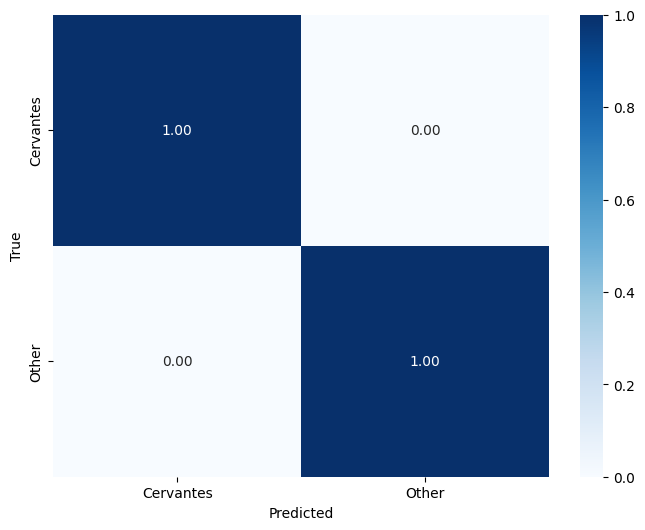

In [83]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

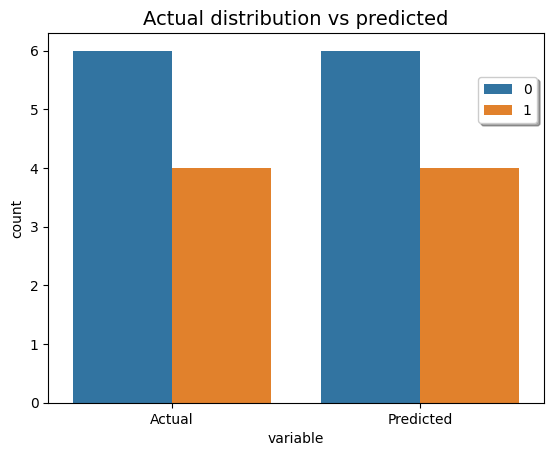

In [84]:
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

#### with weighted probability

In [85]:
res_lst = list()
for threshold in np.arange(0.41, 0.59, 0.01):
    for single_threshold in np.arange(0.11, 0.29, 0.01):
        class_report, y_pred, f1_score_ensemble = ensamble_prob_weighted(probs, y_test, single_threshold=single_threshold, threshold=threshold)
        positive_class_f1 = (class_report.split('\n')[3].split()[3])
        if float(positive_class_f1) > 0:
            res_lst.append((f1_score_ensemble, positive_class_f1, (single_threshold, threshold)))
sorted(res_lst, reverse=True)[:5]

[(1.0, '1.00', (0.2799999999999999, 0.42)),
 (1.0, '1.00', (0.2799999999999999, 0.41)),
 (1.0, '1.00', (0.2699999999999999, 0.42)),
 (1.0, '1.00', (0.2699999999999999, 0.41)),
 (1.0, '1.00', (0.2599999999999999, 0.42))]

In [86]:
class_report, y_pred, f1_score_ensemble = ensamble_prob_weighted(probs, y_test, single_threshold=0.28, threshold=0.45) #267
print(np.sum(y_pred))
print(class_report)

2
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.50      0.67         4

    accuracy                           0.80        10
   macro avg       0.88      0.75      0.76        10
weighted avg       0.85      0.80      0.78        10



In [87]:
res_df.loc[idx_res] = {'Grid':1,
                'Ensemble': 1,
                'Stacked': 0,
                'Pipeline': 0, 
                'With_proba': 1,
                'Weighted': 1, 
                'Whole_docs': 1,
                'F1_weighted': round(f1_score_ensemble, 2)
}
idx_res+=1
res_df.shape

(6, 8)

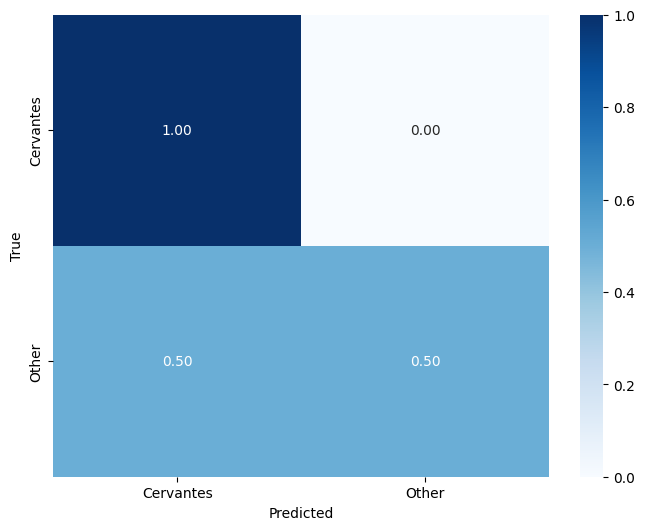

In [88]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


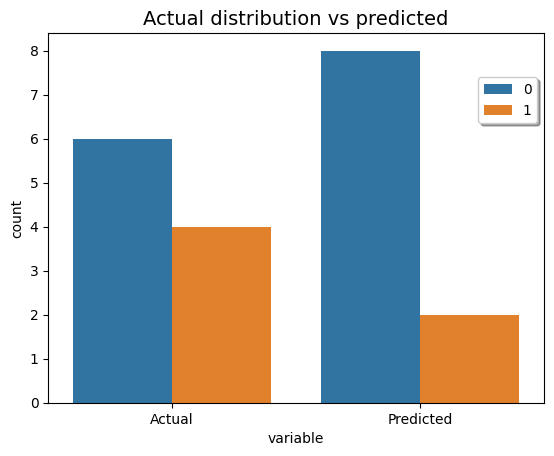

In [89]:
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

### on fragmented docs

In [90]:
param_grid= {'learner__estimator__C': [0.1, 1, 10, 100],
             'learner__estimator__dual': ['auto'],
             'learner__estimator__random_state': [0]}

fw_clf, fw_pred, fw_score, fw_yproba_dev,fw_yproba_test = build_model(feature_extractor=fw_reductor, X_dev=fw_red, y_dev=y_dev, groups=groups_dev, X_test=fw_red_test_fragments,param_grid=param_grid)
me_clf, me_pred, me_score, me_yproba_dev,me_yproba_test = build_model(feature_extractor=me_reductor, X_dev=me_red, y_dev=y_dev, groups=groups_dev, X_test=me_red_test_fragments,param_grid=param_grid)
wm_clf, wm_pred, wm_score, wm_yproba_dev,wm_yproba_test = build_model(feature_extractor=wm_reductor, X_dev=wm_red, y_dev=y_dev, groups=groups_dev, X_test=wm_red_test_fragments,param_grid=param_grid)
pos_clf, pos_pred, pos_score, pos_yproba_dev,pos_yproba_test = build_model(feature_extractor=pos_reductor, X_dev=pos_red, y_dev=y_dev, groups=groups_dev, X_test=pos_red_test_fragments,param_grid=param_grid)
sl_clf, sl_pred, sl_score, sl_yproba_dev,sl_yproba_test = build_model(feature_extractor=sl_reductor, X_dev=sl_red, y_dev=y_dev, groups=groups_dev, X_test=sl_red_test_fragments,param_grid=param_grid)

FeatureSetReductor for FeaturesFunctionWords
Best estimator: Pipeline(steps=[('learner',
                 CalibratedClassifierCV(estimator=LinearSVC(C=10,
                                                            class_weight='balanced',
                                                            dual='auto',
                                                            max_iter=10000,
                                                            random_state=0)))]) 
Best score: 0.7920410717040383

FeatureSetReductor for FeaturesMendenhall
Best estimator: Pipeline(steps=[('learner',
                 CalibratedClassifierCV(estimator=LinearSVC(C=100,
                                                            class_weight='balanced',
                                                            dual='auto',
                                                            max_iter=10000,
                                                            random_state=0)))]) 
Best score: 0.6633749101903936

#### stacking classifier - fun(tat)

In [91]:
base_clfs = [LinearSVC(random_state=42, class_weight='balanced', max_iter=10000, dual='auto') for i in range(5)]
feature_spaces = [fw_red,sl_red,me_red,wm_red,pos_red]
feature_spaces_test = [fw_red_test_fragments,sl_red_test_fragments,me_red_test_fragments,wm_red_test_fragments,pos_red_test_fragments]
posterior_probs = [fit_base_clf(clf, feature_spaces[i], y_dev,feature_spaces_test[i], groups=groups_dev) for i, clf in enumerate(base_clfs)]
# clf_names= ['fw_clf','sl_clf','me_clf','wm_clf','pos_clf' ]
# estimators = [(clf_names[i], fitted_clf.estimator) for i, (fitted_clf,_,_) in enumerate(posterior_probs)]
probs_unstacked_dev = [proba for proba, _ in posterior_probs]
probs_unstacked_test = [proba for _, proba in posterior_probs]
posterior_probs_dev = np.column_stack([prob for prob in probs_unstacked_dev])
posterior_probs_test = np.column_stack([prob for prob in probs_unstacked_test])
final_estimator = SVC(class_weight='balanced', random_state=42)

param_grid = [{
    'kernel': ['rbf', 'sigmoid'],
    'C' : [0.1, 1, 10, 100],
    'gamma' : [0.0001, 0.001, 0.1, 1, 'scale', 'auto']
},
{
    'kernel' : ['poly'],
    'C' : [0.1, 1, 10, 100],
    'degree': [1, 2, 3, 4, 5],
    'gamma' : [0.0001, 0.001, 0.1, 1, 'scale', 'auto']
}]

stacking_classifier = stacking_classification(final_estimator, posterior_probs_dev, y_dev, param_grid, groups_dev)

SVC(C=100, class_weight='balanced', degree=1, gamma=1, kernel='poly',
    random_state=42) 0.8811135933333446


In [92]:
clf = stacking_classifier
y_pred_fragments = clf.predict(posterior_probs_test)
acc = accuracy_score(y_test_frag, y_pred_fragments)
f1_frag = f1_score(y_test_frag, y_pred_fragments, average='weighted')
print('Results on fragments:') 
print('Accuracy:', acc) 
print('Weighted f1:',f1_frag)

Results on fragments:
Accuracy: 0.8333333333333334
Weighted f1: 0.8430050266261883


In [93]:
print(classification_report(y_test_frag, y_pred_fragments))

              precision    recall  f1-score   support

           0       0.93      0.86      0.90       588
           1       0.51      0.69      0.58       120

    accuracy                           0.83       708
   macro avg       0.72      0.78      0.74       708
weighted avg       0.86      0.83      0.84       708



In [94]:
res_df.loc[idx_res] = {'Grid':0,
                'Ensemble': 1,
                'Stacked': 1,
                'Pipeline': 0, 
                'With_proba': 0,
                'Weighted': 0, 
                'Whole_docs': 0,
                'F1_weighted': round(f1_frag, 2)
}
idx_res+=1
res_df.shape

(7, 8)

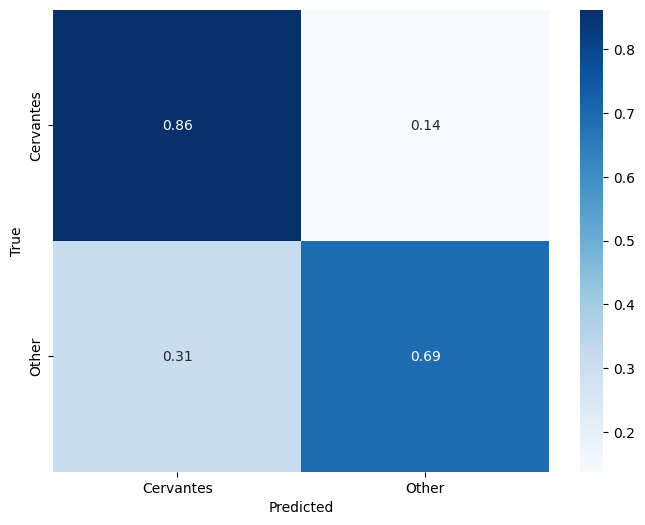

In [95]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test_frag, y_pred_fragments, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#### stacking classifier - fun(kfcv)

In [96]:
base_clfs = [LinearSVC(random_state=42, class_weight='balanced', max_iter=10000, dual='auto') for i in range(5)]
feature_spaces = [fw_red,sl_red,me_red,wm_red,pos_red]
feature_spaces_test = [fw_red_test_fragments,sl_red_test_fragments,me_red_test_fragments,wm_red_test_fragments,pos_red_test_fragments]
posterior_probs = [fit_base_clf(clf, feature_spaces[i], y_dev,feature_spaces_test[i], groups=groups_dev, fun_kfcv=True) for i, clf in enumerate(base_clfs)]
#clf_names= ['fw_clf','sl_clf','me_clf','wm_clf','pos_clf' ]
#estimators = [(clf_names[i], fitted_clf.estimator) for i, (fitted_clf,_,_) in enumerate(fitted_clfs)]
probs_unstacked_dev = [proba for proba,_ in posterior_probs]
probs_unstacked_test = [proba for _, proba in posterior_probs]
posterior_probs_dev = np.column_stack([prob for prob in probs_unstacked_dev])
posterior_probs_test = np.column_stack([prob for prob in probs_unstacked_test])
final_estimator = SVC(class_weight='balanced', random_state=42)

param_grid = [{
    'kernel': ['rbf', 'sigmoid'],
    'C' : [0.1, 1, 10, 100],
    'gamma' : [0.0001, 0.001, 0.1, 1, 'scale', 'auto']
},
{
    'kernel' : ['poly'],
    'C' : [0.1, 1, 10, 100],
    'degree': [1, 2, 3, 4, 5],
    'gamma' : [0.0001, 0.001, 0.1, 1, 'scale', 'auto']
}]

stacking_classifier = stacking_classification(final_estimator, posterior_probs_dev, y_dev, param_grid, groups_dev)

SVC(C=100, class_weight='balanced', gamma=0.0001, random_state=42) 0.538537220916023


In [97]:
clf = stacking_classifier
y_pred_fragments = clf.predict(posterior_probs_test)
acc = accuracy_score(y_test_frag, y_pred_fragments)
f1_frag = f1_score(y_test_frag, y_pred_fragments, average='weighted')
print('Results on fragments:') 
print('Accuracy:', acc) 
print('Weighted f1:',f1_frag)

Results on fragments:
Accuracy: 0.1694915254237288
Weighted f1: 0.049127978383689506


In [98]:
print(classification_report(y_test_frag, y_pred_fragments))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       588
           1       0.17      1.00      0.29       120

    accuracy                           0.17       708
   macro avg       0.08      0.50      0.14       708
weighted avg       0.03      0.17      0.05       708



#### stacking classifier with optimized base classifiers

In [99]:
estimators = [fw_clf,sl_clf,me_clf,wm_clf,pos_clf]
posterior_probs = [fit_base_clf(clf, feature_spaces[i], y_dev,feature_spaces_test[i], groups=groups_dev) for i, clf in enumerate(estimators)]
probs_unstacked_dev = [dev_proba for dev_proba, _ in posterior_probs]
probs_unstacked_test = [test_proba for _, test_proba in posterior_probs]
posterior_probs_dev = np.column_stack([prob for prob in probs_unstacked_dev])
posterior_probs_test = np.column_stack([prob for prob in probs_unstacked_test])
final_estimator = SVC(class_weight='balanced', random_state=42)

param_grid = [{
    'kernel': ['rbf', 'sigmoid'],
    'C' : [0.1, 1, 10, 100],
    'gamma' : [0.0001, 0.001, 0.1, 1, 'scale', 'auto']
},
{
    'kernel' : ['poly'],
    'C' : [0.1, 1, 10, 100],
    'degree': [1, 2, 3, 4, 5],
    'gamma' : [0.0001, 0.001, 0.1, 1, 'scale', 'auto']
}]

stacking_classifier = stacking_classification(final_estimator, posterior_probs_dev, y_dev, param_grid, groups_dev)


SVC(C=0.1, class_weight='balanced', degree=2, gamma=0.1, kernel='poly',
    random_state=42) 0.890731005885294


In [100]:
clf = stacking_classifier
y_pred_fragments = clf.predict(posterior_probs_test)
acc = accuracy_score(y_test_frag, y_pred_fragments)
f1_frag = f1_score(y_test_frag, y_pred_fragments, average='weighted')
print('Results on fragments:') 
print('Accuracy:', acc) 
print('Weighted f1:',f1_frag)

Results on fragments:
Accuracy: 0.844632768361582
Weighted f1: 0.8475311261437419


In [101]:
print(classification_report(y_test_frag, y_pred_fragments))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91       588
           1       0.54      0.59      0.56       120

    accuracy                           0.84       708
   macro avg       0.73      0.74      0.73       708
weighted avg       0.85      0.84      0.85       708



In [102]:
res_df.loc[idx_res] = {'Grid':1,
                'Ensemble': 1,
                'Stacked': 1,
                'Pipeline': 0, 
                'With_proba': 0,
                'Weighted': 0, 
                'Whole_docs': 0,
                'F1_weighted': round(f1_frag, 2)
}
idx_res+=1
res_df.shape

(8, 8)

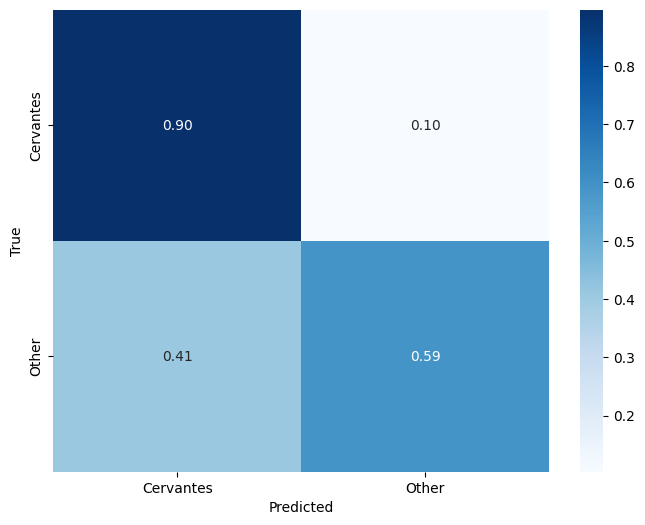

In [103]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test_frag, y_pred_fragments, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

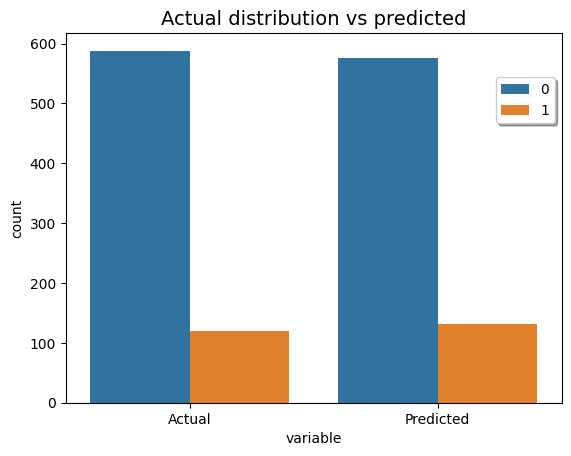

In [104]:
df_res = pd.DataFrame({'Actual': y_test_frag, 'Predicted': y_pred_fragments})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

#### with majority vote

In [105]:
for i in np.arange(0.1, 1, 0.1):
    ensemble_preds, f1_score_ensemble = ensemble(predictions=[fw_pred, sl_pred, me_pred, wm_pred, pos_pred], 
                                                y_test=y_test_frag, majority_vote=True, threshold=i) 
    print('threshold:', round(i,2), 'f1:', round(f1_score_ensemble,2), 'Positive preds:', sum(ensemble_preds))

threshold: 0.1 f1: 0.77 Positive preds: 171
threshold: 0.2 f1: 0.77 Positive preds: 171
threshold: 0.3 f1: 0.86 Positive preds: 71
threshold: 0.4 f1: 0.86 Positive preds: 71
threshold: 0.5 f1: 0.9 Positive preds: 12
threshold: 0.6 f1: 0.9 Positive preds: 12
threshold: 0.7 f1: 0.91 Positive preds: 0
threshold: 0.8 f1: 0.91 Positive preds: 0
threshold: 0.9 f1: 0.91 Positive preds: 0


In [106]:
ensemble_preds, f1_score_ensemble = ensemble(predictions=[fw_pred, sl_pred, me_pred, wm_pred, pos_pred], 
                                             y_test=y_test_frag, majority_vote=True, threshold=0.4) 
                                            # ma stesso risultato anche con numeri molto più piccoli
print(classification_report(y_test_frag, ensemble_preds))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       588
           1       0.56      0.33      0.42       120

    accuracy                           0.84       708
   macro avg       0.72      0.64      0.66       708
weighted avg       0.82      0.84      0.83       708



In [107]:
res_df.loc[idx_res] = {'Grid':1,
                'Ensemble': 1,
                'Stacked': 0,
                'Pipeline': 0, 
                'With_proba': 0,
                'Weighted': 0, 
                'Whole_docs': 0,
                'F1_weighted': round(f1_score_ensemble, 2)
}
idx_res+=1
res_df.shape

(9, 8)

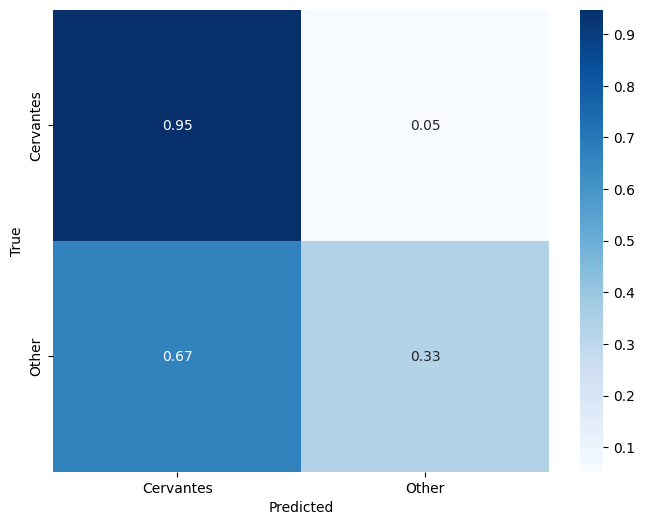

In [108]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test_frag, ensemble_preds, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

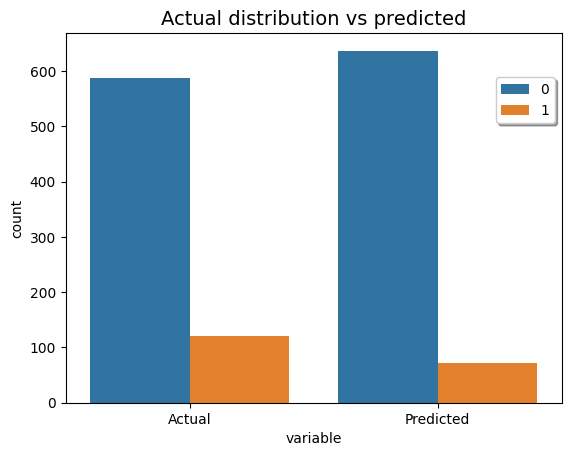

In [109]:
df_res = pd.DataFrame({'Actual': y_test_frag, 'Predicted': ensemble_preds})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

#### with weighting

In [110]:
for i in np.arange(0.1, 1, 0.1):
    ensemble_preds, f1_score_ensemble = ensemble_preds, f1_score_ensemble = ensemble(predictions=[fw_pred, sl_pred, me_pred, wm_pred, pos_pred],
                                                                                      y_test=y_test_frag, threshold=i)

    print('threshold:', round(i,2), 'f1:', round(f1_score_ensemble,2), 'Positive preds:', sum(ensemble_preds))

threshold: 0.1 f1: 0.77 Positive preds: 171
threshold: 0.2 f1: 0.86 Positive preds: 71
threshold: 0.3 f1: 0.86 Positive preds: 71
threshold: 0.4 f1: 0.9 Positive preds: 12
threshold: 0.5 f1: 0.91 Positive preds: 0
threshold: 0.6 f1: 0.91 Positive preds: 0
threshold: 0.7 f1: 0.91 Positive preds: 0
threshold: 0.8 f1: 0.91 Positive preds: 0
threshold: 0.9 f1: 0.91 Positive preds: 0


In [111]:
ensemble_preds, f1_score_ensemble = ensemble(predictions=[fw_pred, sl_pred, me_pred, wm_pred, pos_pred], y_test=y_test_frag, threshold=0.3)

print(classification_report(y_test_frag, ensemble_preds))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       588
           1       0.56      0.33      0.42       120

    accuracy                           0.84       708
   macro avg       0.72      0.64      0.66       708
weighted avg       0.82      0.84      0.83       708



In [112]:
res_df.loc[idx_res] = {'Grid':1,
                'Ensemble': 1,
                'Stacked': 0,
                'Pipeline': 0, 
                'With_proba': 0,
                'Weighted': 1, 
                'Whole_docs': 0,
                'F1_weighted': round(f1_score_ensemble, 2)
}
idx_res+=1
res_df.shape

(10, 8)

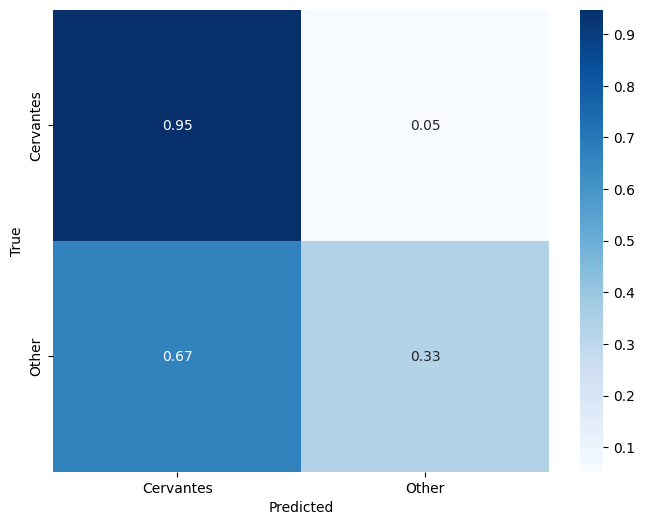

In [113]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test_frag, ensemble_preds, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

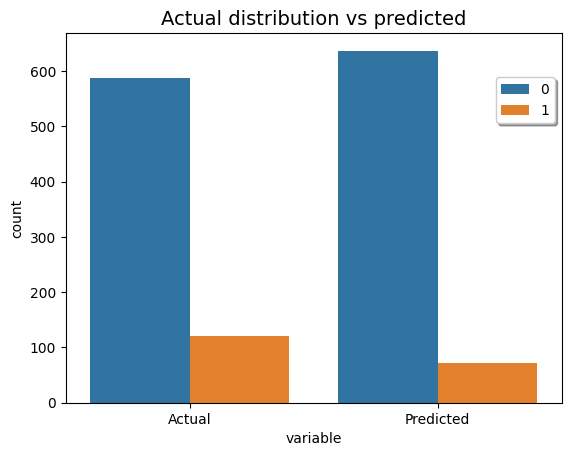

In [114]:
df_res = pd.DataFrame({'Actual': y_test_frag, 'Predicted': ensemble_preds})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

#### with probability

In [115]:
probs = [fw_yproba_test, sl_yproba_test, me_yproba_test,wm_yproba_test,pos_yproba_test]
for i in np.arange(0.1, 1, 0.1):
    class_report, y_pred,f1_score_ensemble = ensamble_prob(probs, y_test_frag, threshold=i)
    print('threshold:', round(i,2), 'f1:', round(f1_score_ensemble,3), 'Positive preds:', sum(y_pred))

threshold: 0.1 f1: 0.379 Positive preds: 541
threshold: 0.2 f1: 0.699 Positive preds: 288
threshold: 0.3 f1: 0.857 Positive preds: 123
threshold: 0.4 f1: 0.887 Positive preds: 51
threshold: 0.5 f1: 0.898 Positive preds: 12
threshold: 0.6 f1: 0.907 Positive preds: 1
threshold: 0.7 f1: 0.907 Positive preds: 0
threshold: 0.8 f1: 0.907 Positive preds: 0
threshold: 0.9 f1: 0.907 Positive preds: 0


In [116]:
class_report, y_pred,f1_score_ensemble = ensamble_prob(probs, y_test_frag, threshold=0.3) 
#print(np.sum(y_pred))
print(class_report)

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       588
           1       0.58      0.59      0.58       120

    accuracy                           0.86       708
   macro avg       0.75      0.75      0.75       708
weighted avg       0.86      0.86      0.86       708



In [117]:
res_df.loc[idx_res] = {'Grid':1,
                'Ensemble': 1,
                'Stacked': 0,
                'Pipeline': 0, 
                'With_proba': 1,
                'Weighted': 0, 
                'Whole_docs': 0,
                'F1_weighted': round(f1_score_ensemble, 2)
}
idx_res+=1
res_df.shape

(11, 8)

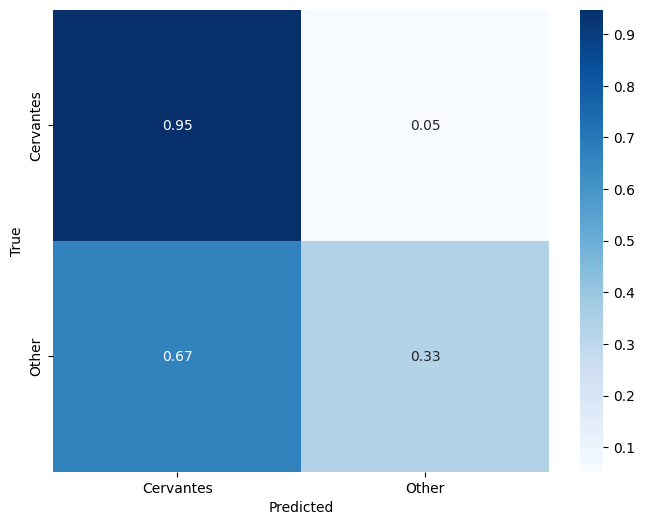

In [118]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test_frag, ensemble_preds, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

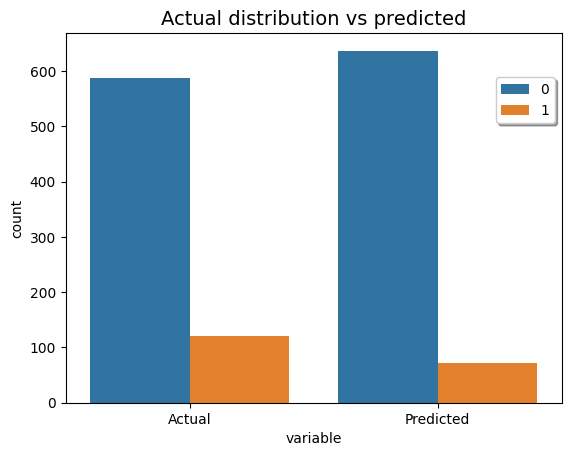

In [119]:
df_res = pd.DataFrame({'Actual': y_test_frag, 'Predicted': ensemble_preds})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

#### with weighted probability

In [120]:
res_lst = list()
for threshold in np.arange(0.1, 1, 0.1):
    for single_threshold in np.arange(0.11, 0.29, 0.01):
        class_report, y_pred, f1_score_ensemble = ensamble_prob_weighted(probs, y_test_frag, single_threshold=single_threshold, threshold=threshold)
        positive_class_f1 = (class_report.split('\n')[3].split()[3])
        if float(positive_class_f1) > 0:
            res_lst.append((f1_score_ensemble, positive_class_f1, (single_threshold, threshold), sum(y_pred)))
sorted(res_lst, reverse=True)[:10]

[(0.9077221289673612, '0.61', (0.20999999999999996, 0.6), 68),
 (0.9072370459344061, '0.58', (0.21999999999999995, 0.6), 62),
 (0.9055373147572988, '0.61', (0.16999999999999998, 0.7000000000000001), 71),
 (0.9055180736108825, '0.57', (0.17999999999999997, 0.7000000000000001), 60),
 (0.9050267999420541, '0.44', (0.22999999999999993, 0.7000000000000001), 36),
 (0.9048258404293094, '0.40', (0.23999999999999994, 0.7000000000000001), 31),
 (0.9047725736647734, '0.52', (0.19999999999999996, 0.7000000000000001), 50),
 (0.9046340938085061, '0.55', (0.18999999999999995, 0.7000000000000001), 56),
 (0.9046115187471597, '0.48', (0.21999999999999995, 0.7000000000000001), 43),
 (0.9042888298958546, '0.49', (0.20999999999999996, 0.7000000000000001), 46)]

In [121]:
class_report, y_pred,f1_score_ensemble = ensamble_prob_weighted(probs, y_test_frag, threshold=0.6, single_threshold=0.22) #267
print(np.sum(y_pred))
print(class_report)

62
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       588
           1       0.85      0.44      0.58       120

    accuracy                           0.89       708
   macro avg       0.88      0.71      0.76       708
weighted avg       0.89      0.89      0.88       708



In [122]:
res_df.loc[idx_res] = {'Grid':1,
                'Ensemble': 1,
                'Stacked': 0,
                'Pipeline': 0, 
                'With_proba': 1,
                'Weighted': 1, 
                'Whole_docs': 0,
                'F1_weighted': round(f1_score_ensemble, 2)
}
idx_res+=1
res_df.shape

(12, 8)

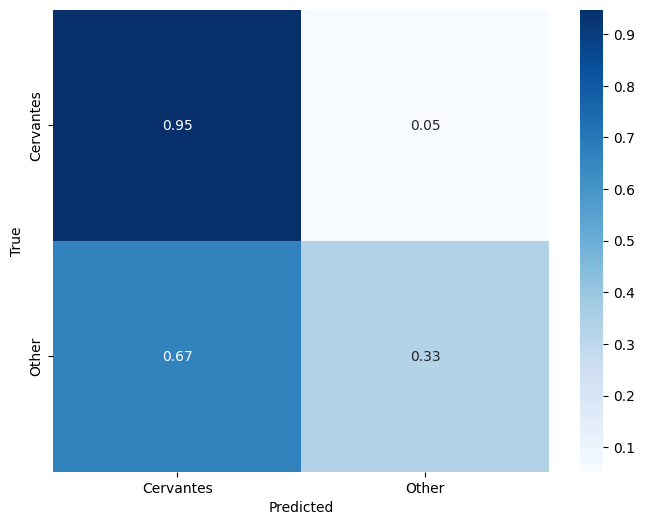

In [123]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test_frag, ensemble_preds, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

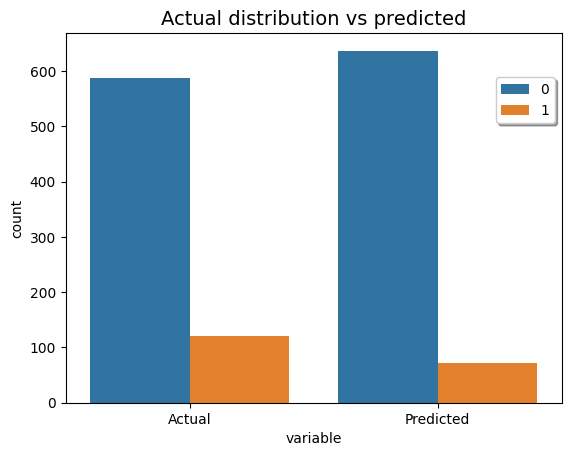

In [124]:
df_res = pd.DataFrame({'Actual': y_test_frag, 'Predicted': ensemble_preds})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

## Ensamble & Hyperparameter search \w Pipeline object

### on whole docs

In [125]:
function_words_extractor2 = FeaturesFunctionWords(language='spanish')
mendenhall_extractor2 = FeaturesMendenhall(upto=20)
words_masker2 = FeaturesDVEX(function_words=fuction_ws)
sentence_len_extractor2 = FeaturesSentenceLength()
POS_extractor2 = FeaturesPOST(language='spanish')

fw_features = function_words_extractor2.fit_transform(X_dev)
fw_features_test = function_words_extractor2.transform(X_test)

sl_features = sentence_len_extractor2.fit_transform(X_dev)
sl_features_test = sentence_len_extractor2.transform(X_test)

me_features = mendenhall_extractor2.fit_transform(X_dev)
me_features_test = mendenhall_extractor2.transform(X_test)

wm_features = words_masker2.fit_transform(X_dev)
wm_features_test = words_masker2.transform(X_test)

pos_features = POS_extractor2.fit_transform(X_dev)
pos_features_test = POS_extractor2.transform(X_test)

loading cache from .postcache/dict.pkl


In [126]:
feature_sets_dict = {function_words_extractor:fw_features,
                    sentence_len_extractor:sl_features,
                    mendenhall_extractor:me_features,
                    words_masker: wm_features, 
                    POS_extractor:pos_features}

feature_sets_test = [fw_features_test, sl_features_test, me_features_test, wm_features_test, pos_features_test]

res_dict = dict()
estimators = list()
predictions = list()
probabilities_dev = list()
probabilities_test = list()
for idx, (feature_name, feature_set) in enumerate(feature_sets_dict.items()):
    print('Feature extractor:', feature_name)

    param_grid = {
        'sel__k': [round(feature_set.shape[1] * val) for val in np.arange(0.1, 1.1, 0.1)],
        'learner__estimator__C': [0.1, 1, 10, 100],
        'learner__estimator__dual': ['auto'],
        'learner__estimator__random_state': [0]
            }

    fs_clf, fs_pred, fs_score, fs_proba_dev, fs_proba_test = build_model(X_dev=feature_set, y_dev=y_dev, groups=groups_dev, X_test=feature_sets_test[idx],
                               param_grid=param_grid, pipe=True)
    res_dict[str(feature_name)] = fs_score
    estimators.append(fs_clf)
    predictions.append(fs_pred)
    probabilities_dev.append(fs_proba_dev)
    probabilities_test.append(fs_proba_test)

  

Feature extractor: FeaturesFunctionWords
None
Best estimator: Pipeline(steps=[('sel',
                 SelectKBest(k=156,
                             score_func=<function chi2 at 0x7f3e8b91dbd0>)),
                ('learner',
                 CalibratedClassifierCV(estimator=LinearSVC(C=100,
                                                            class_weight='balanced',
                                                            dual='auto',
                                                            max_iter=10000,
                                                            random_state=0)))]) 
Best score: 0.7664745496921007

Feature extractor: FeaturesSentenceLength


None
Best estimator: Pipeline(steps=[('sel',
                 SelectKBest(k=499,
                             score_func=<function chi2 at 0x7f3e8b91dbd0>)),
                ('learner',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            dual='auto',
                                                            max_iter=10000,
                                                            random_state=0)))]) 
Best score: 0.6775503997599753

Feature extractor: FeaturesMendenhall
None
Best estimator: Pipeline(steps=[('sel',
                 SelectKBest(k=2,
                             score_func=<function chi2 at 0x7f3e8b91dbd0>)),
                ('learner',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                          

In [127]:
res_dict

{'FeaturesFunctionWords': 0.7664745496921007,
 'FeaturesSentenceLength': 0.6775503997599753,
 'FeaturesMendenhall': 0.6813789730430108,
 'FeaturesDVEX': 0.7855238695868872,
 'FeaturesPOST': 0.7081946180194723}

#### stacking classifier

In [140]:
estimators = [fw_clf,sl_clf,me_clf,wm_clf,pos_clf]
feature_spaces = [fw_features, sl_features, me_features, wm_features, pos_features]
feature_spaces_test = [fw_features_test, sl_features_test, me_features_test, wm_features_test, pos_features_test]
posterior_probs = [fit_base_clf(clf, feature_spaces[i], y_dev,feature_spaces_test[i], groups=groups_dev) for i, clf in enumerate(estimators)]
probs_unstacked_dev = [dev_proba for dev_proba, _ in posterior_probs]
probs_unstacked_test = [test_proba for _, test_proba in posterior_probs]
posterior_probs_dev = np.column_stack([prob for prob in probs_unstacked_dev])
posterior_probs_test = np.column_stack([prob for prob in probs_unstacked_test])
final_estimator = SVC(class_weight='balanced', random_state=42)


param_grid = [{
    'kernel': ['rbf', 'sigmoid'],
    'C' : [0.1, 1, 10, 100],
    'gamma' : [0.0001, 0.001, 0.1, 1, 'scale', 'auto']
},
{
    'kernel' : ['poly'],
    'C' : [0.1, 1, 10, 100],
    'degree': [1, 2, 3, 4, 5],
    'gamma' : [0.0001, 0.001, 0.1, 1, 'scale', 'auto']
}]

stacking_classifier = stacking_classification(final_estimator, posterior_probs_dev, y_dev, param_grid, groups_dev)

SVC(C=0.1, class_weight='balanced', degree=1, kernel='poly', random_state=42) 0.9052492646848576


In [141]:
clf = stacking_classifier
y_pred = clf.predict(posterior_probs_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print('Results on whole documents:') 
print('Accuracy (on whole documents):', acc) 
print('Weighted f1:',f1)
print()

Results on whole documents:
Accuracy (on whole documents): 1.0
Weighted f1: 1.0



In [142]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [143]:
res_df.loc[idx_res] = {'Grid':1,
                'Ensemble': 1,
                'Stacked': 1,
                'Pipeline': 1, 
                'With_proba': 0,
                'Weighted': 0, 
                'Whole_docs': 1,
                'F1_weighted': round(f1, 2)
}
idx_res+=1
res_df.shape

(13, 8)

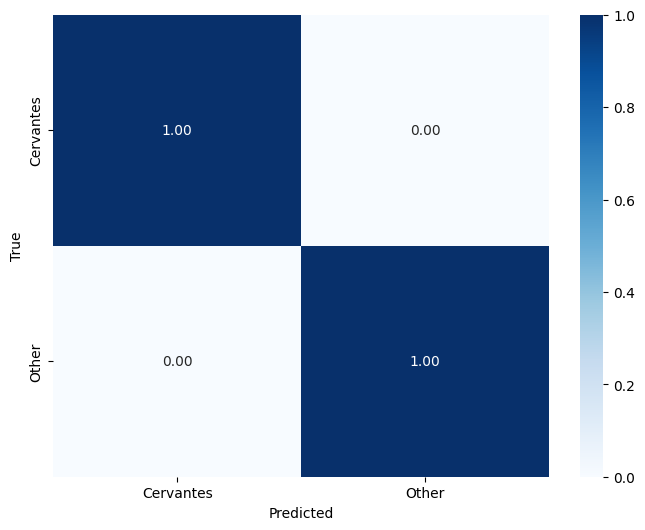

In [144]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#### with majority vote

In [145]:
thresholds=list()

for threshold in np.arange(0.01, 0.9, 0.05):
    ensemble_preds, f1_score_ensemble = ensemble(predictions=predictions, y_test=y_test, threshold=threshold, majority_vote=True)
    thresholds.append((f1_score_ensemble, threshold, np.sum(ensemble_preds)))

sorted(thresholds, reverse=True)


[(0.819047619047619, 0.36000000000000004, 2),
 (0.819047619047619, 0.31000000000000005, 2),
 (0.819047619047619, 0.26, 2),
 (0.819047619047619, 0.21000000000000002, 2),
 (0.8, 0.16000000000000003, 6),
 (0.8, 0.11, 6),
 (0.8, 0.060000000000000005, 6),
 (0.8, 0.01, 6),
 (0.7499999999999999, 0.8600000000000001, 0),
 (0.7499999999999999, 0.81, 0),
 (0.7499999999999999, 0.76, 0),
 (0.7499999999999999, 0.7100000000000001, 0),
 (0.7499999999999999, 0.66, 0),
 (0.7499999999999999, 0.6100000000000001, 0),
 (0.7499999999999999, 0.56, 0),
 (0.7499999999999999, 0.51, 0),
 (0.7499999999999999, 0.46, 0),
 (0.7499999999999999, 0.41000000000000003, 0)]

In [146]:
ensemble_preds, f1_score_ensemble = ensemble(predictions=predictions, 
                                             y_test=y_test, majority_vote=True, threshold=0.36) 
                                            # ma stesso risultato anche con numeri molto più piccoli
print(classification_report(y_test, ensemble_preds))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.50      0.67         4

    accuracy                           0.80        10
   macro avg       0.88      0.75      0.76        10
weighted avg       0.85      0.80      0.78        10



In [147]:
res_df.loc[idx_res] = {'Grid':1,
                'Ensemble': 1,
                'Stacked': 0,
                'Pipeline': 1, 
                'With_proba': 0,
                'Weighted': 0, 
                'Whole_docs': 1,
                'F1_weighted': round(f1_score_ensemble, 2)
}
idx_res+=1
res_df.shape

(14, 8)

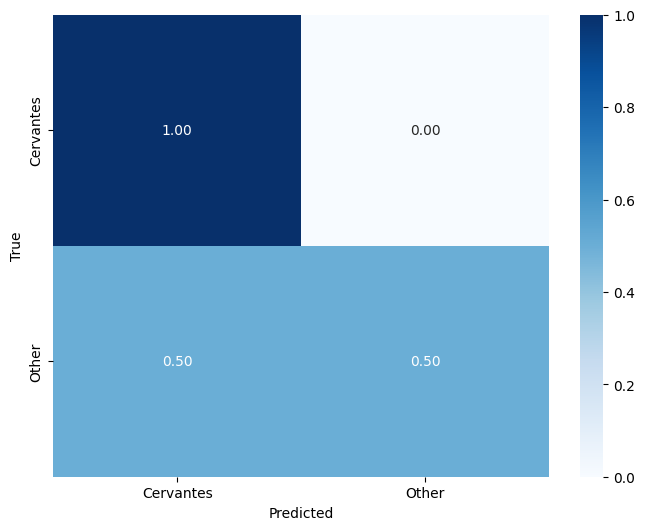

In [148]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test, ensemble_preds, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

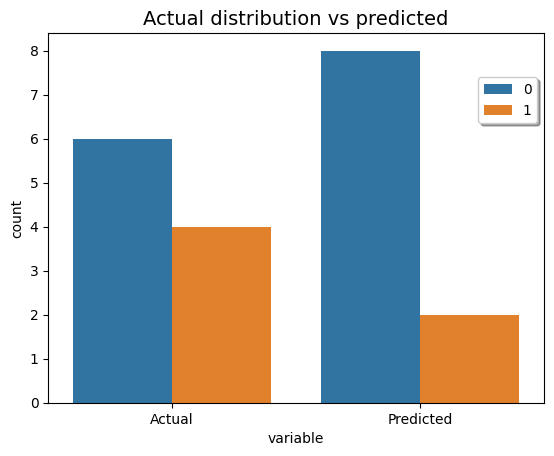

In [149]:
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': ensemble_preds})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

#### with weighting

In [150]:
thresholds=list()

for threshold in np.arange(0.01, 0.9, 0.05):
    ensemble_preds, f1_score_ensemble = ensemble(predictions=predictions, y_test=y_test, threshold=threshold)
    thresholds.append((f1_score_ensemble, threshold, np.sum(ensemble_preds)))

sorted(thresholds, reverse=True)


[(0.819047619047619, 0.31000000000000005, 2),
 (0.819047619047619, 0.26, 2),
 (0.819047619047619, 0.21000000000000002, 2),
 (0.819047619047619, 0.16000000000000003, 2),
 (0.8, 0.11, 6),
 (0.8, 0.060000000000000005, 6),
 (0.8, 0.01, 6),
 (0.7499999999999999, 0.8600000000000001, 0),
 (0.7499999999999999, 0.81, 0),
 (0.7499999999999999, 0.76, 0),
 (0.7499999999999999, 0.7100000000000001, 0),
 (0.7499999999999999, 0.66, 0),
 (0.7499999999999999, 0.6100000000000001, 0),
 (0.7499999999999999, 0.56, 0),
 (0.7499999999999999, 0.51, 0),
 (0.7499999999999999, 0.46, 0),
 (0.7499999999999999, 0.41000000000000003, 0),
 (0.7499999999999999, 0.36000000000000004, 0)]

In [151]:
ensemble_preds, f1_score_ensemble = ensemble(predictions=predictions, y_test=y_test, threshold=0.31)
#print(f1_score_ensemble)

print(classification_report(y_test, ensemble_preds))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.50      0.67         4

    accuracy                           0.80        10
   macro avg       0.88      0.75      0.76        10
weighted avg       0.85      0.80      0.78        10



In [152]:
res_df.loc[idx_res] = {'Grid':1,
                'Ensemble': 1,
                'Stacked': 0,
                'Pipeline': 1, 
                'With_proba': 0,
                'Weighted': 1, 
                'Whole_docs': 1,
                'F1_weighted': round(f1_score_ensemble, 2)
}
idx_res+=1
res_df.shape

(15, 8)

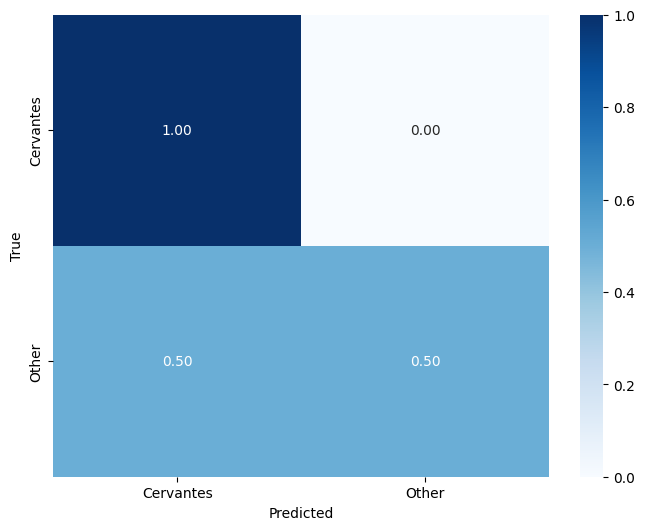

In [153]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test, ensemble_preds, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

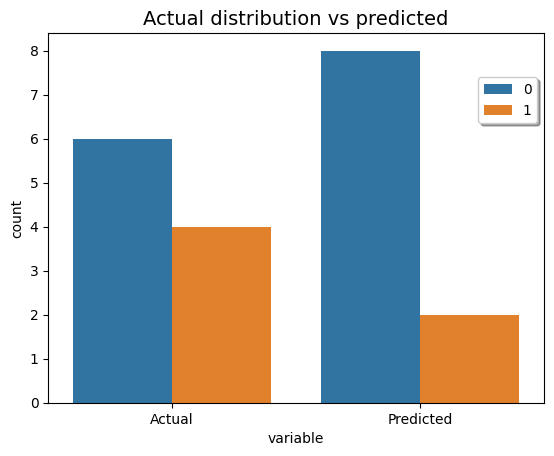

In [154]:
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': ensemble_preds})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

#### with probabilities

In [155]:
for i in np.arange(0.1, 1, 0.1):
    class_report, y_pred,f1_score_ensemble =  ensamble_prob(probabilities_test, y_test, threshold=i) #267
    print('threshold:', round(i,2), 'f1:',round(f1_score_ensemble,2), 'Positive class preds:', sum(y_pred))

threshold: 0.1 f1: 0.57 Positive class preds: 10
threshold: 0.2 f1: 0.9 Positive class preds: 5
threshold: 0.3 f1: 1.0 Positive class preds: 4
threshold: 0.4 f1: 0.82 Positive class preds: 2
threshold: 0.5 f1: 0.75 Positive class preds: 0
threshold: 0.6 f1: 0.75 Positive class preds: 0
threshold: 0.7 f1: 0.75 Positive class preds: 0
threshold: 0.8 f1: 0.75 Positive class preds: 0
threshold: 0.9 f1: 0.75 Positive class preds: 0


In [156]:
class_repo, y_pred,f1_score_ensemble = ensamble_prob(probabilities_test, y_test, threshold=0.3)
print(class_repo)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [157]:
res_df.loc[idx_res] = {'Grid':1,
                'Ensemble': 1,
                'Stacked': 0,
                'Pipeline': 1, 
                'With_proba': 1,
                'Weighted': 0, 
                'Whole_docs': 1,
                'F1_weighted': round(f1_score_ensemble, 2)
}
idx_res+=1
res_df.shape

(16, 8)

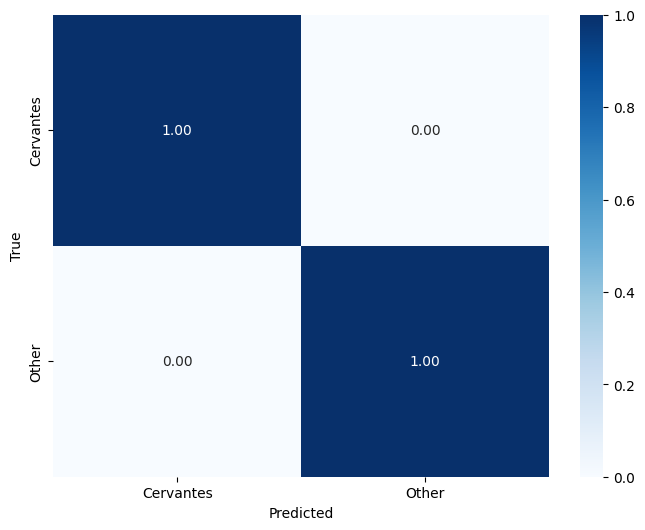

In [158]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

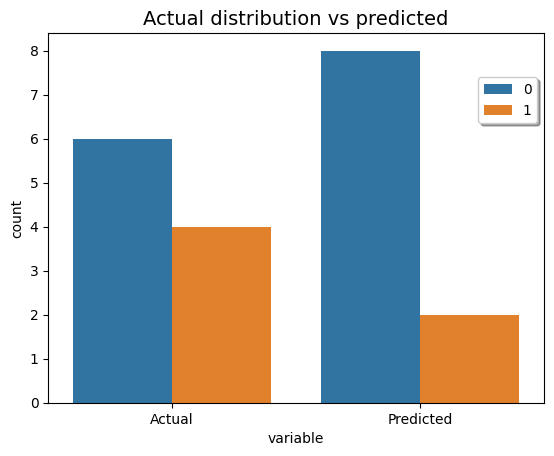

In [159]:

df_res = pd.DataFrame({'Actual': y_test, 'Predicted': ensemble_preds})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

#### with weighted probabilities

In [160]:
res_lst = list()
for threshold in np.arange(0.11, 0.29, 0.01):
    for single_threshold in np.arange(0.21, 0.39, 0.01):
        class_report, y_pred,f1_score_ensemble = ensamble_prob_weighted(probabilities_test, y_test, single_threshold=single_threshold, threshold=threshold)
        positive_class_f1 = (class_report.split('\n')[3].split()[3])
        if float(positive_class_f1) > 0:
            res_lst.append((f1_score_ensemble, positive_class_f1, (single_threshold, threshold)))
sorted(res_lst, reverse=True)[:5]


[(1.0, '1.00', (0.3800000000000001, 0.2799999999999999)),
 (1.0, '1.00', (0.3800000000000001, 0.2699999999999999)),
 (1.0, '1.00', (0.3800000000000001, 0.2599999999999999)),
 (1.0, '1.00', (0.3800000000000001, 0.24999999999999994)),
 (1.0, '1.00', (0.3800000000000001, 0.23999999999999994))]

In [161]:
class_report, y_pred,f1_score_ensemble = ensamble_prob_weighted(probabilities_test, y_test, threshold=0.28, single_threshold=0.33) #267
print(np.sum(y_pred))
print(class_report)

4
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [162]:
res_df.loc[idx_res] = {'Grid':1,
                'Ensemble': 1,
                'Stacked': 0,
                'Pipeline': 1, 
                'With_proba': 1,
                'Weighted': 1, 
                'Whole_docs': 1,
                'F1_weighted': round(f1_score_ensemble, 2)
}
idx_res+=1
res_df.shape

(17, 8)

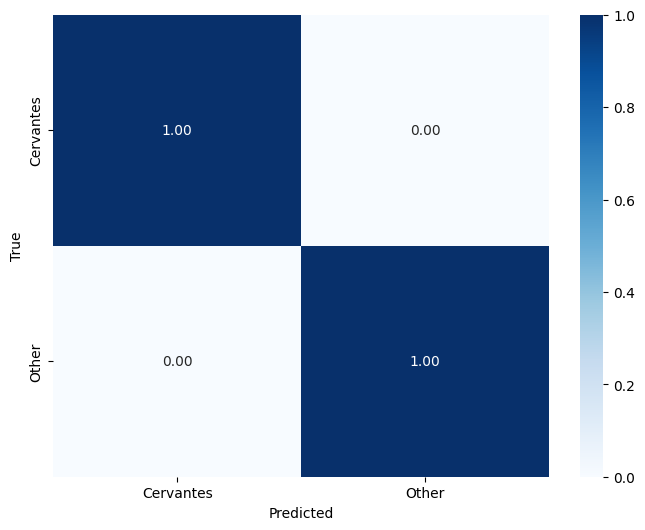

In [163]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

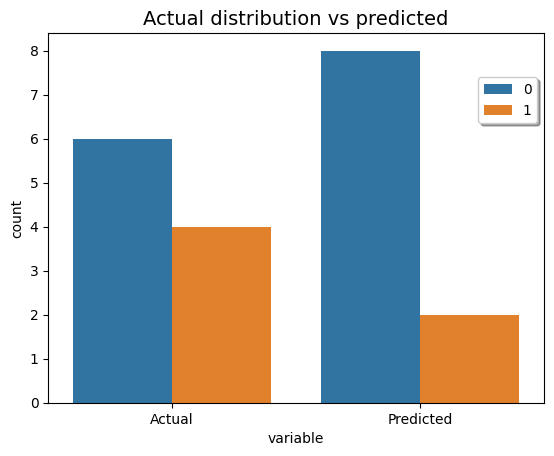

In [164]:
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': ensemble_preds})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

### on fragmented docs

In [165]:
function_words_extractor2 = FeaturesFunctionWords(language='spanish')
mendenhall_extractor2 = FeaturesMendenhall(upto=20)
words_masker2 = FeaturesDVEX(function_words=fuction_ws)
sentence_len_extractor2 = FeaturesSentenceLength()
POS_extractor2 = FeaturesPOST(language='spanish')

fw_features = function_words_extractor2.fit_transform(X_dev)
fw_features_test_frag = function_words_extractor2.transform(X_test_frag)

sl_features = sentence_len_extractor2.fit_transform(X_dev)
sl_features_test_frag = sentence_len_extractor2.transform(X_test_frag)

me_features = mendenhall_extractor2.fit_transform(X_dev)
me_features_test_frag = mendenhall_extractor2.transform(X_test_frag)

wm_features = words_masker2.fit_transform(X_dev)
wm_features_test_frag = words_masker2.transform(X_test_frag)

pos_features = POS_extractor2.fit_transform(X_dev)
pos_features_test_frag = POS_extractor2.transform(X_test_frag)

loading cache from .postcache/dict.pkl


In [167]:
feature_sets_dict = {function_words_extractor:fw_features,
                     sentence_len_extractor:sl_features,
                    mendenhall_extractor:me_features,
                    words_masker: wm_features, 
                    POS_extractor:pos_features}

feature_sets_test = [fw_features_test_frag, sl_features_test_frag, me_features_test_frag, wm_features_test_frag, pos_features_test_frag]

res_dict = dict()
predictions = list()
probabilities_dev = list()
probabilities_test = list()
for idx, (feature_name, feature_set) in enumerate(feature_sets_dict.items()):
    print('Feature extractor:', feature_name)
    param_grid = {
        'sel__k': [round(feature_set.shape[1] * val) for val in np.arange(0.1, 1.1, 0.1)],
        'learner__estimator__C': [0.1, 1, 10, 100],
        'learner__estimator__dual': ['auto'],
        'learner__estimator__random_state': [0]
        }

    fs_clf, fs_pred, fs_score, fs_proba_dev, fs_proba_test = build_model(X_dev=feature_set, y_dev=y_dev, groups=groups_dev, X_test=feature_sets_test[idx],
                               param_grid=param_grid, pipe=True)
    res_dict[str(feature_name)] = fs_score
    predictions.append(fs_pred)
    probabilities_dev.append(fs_proba_dev)
    probabilities_test.append(fs_proba_test)

Feature extractor: FeaturesFunctionWords


None
Best estimator: Pipeline(steps=[('sel',
                 SelectKBest(k=156,
                             score_func=<function chi2 at 0x7f3e8b91dbd0>)),
                ('learner',
                 CalibratedClassifierCV(estimator=LinearSVC(C=100,
                                                            class_weight='balanced',
                                                            dual='auto',
                                                            max_iter=10000,
                                                            random_state=0)))]) 
Best score: 0.7664745496921007

Feature extractor: FeaturesSentenceLength
None
Best estimator: Pipeline(steps=[('sel',
                 SelectKBest(k=499,
                             score_func=<function chi2 at 0x7f3e8b91dbd0>)),
                ('learner',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                    

In [168]:
res_dict

{'FeaturesFunctionWords': 0.7664745496921007,
 'FeaturesSentenceLength': 0.6775503997599753,
 'FeaturesMendenhall': 0.6813789730430108,
 'FeaturesDVEX': 0.7855238695868872,
 'FeaturesPOST': 0.7081946180194723}

#### stacking classifier

In [171]:
estimators = [fw_clf,sl_clf,me_clf,wm_clf,pos_clf]
feature_spaces = [fw_features, sl_features, me_features, wm_features, pos_features]
feature_spaces_test = [fw_features_test_frag, sl_features_test_frag, me_features_test_frag, wm_features_test_frag, pos_features_test_frag]
posterior_probs = [fit_base_clf(clf, feature_spaces[i], y_dev,feature_spaces_test[i], groups=groups_dev) for i, clf in enumerate(estimators)]
probs_unstacked_dev = [dev_proba for dev_proba, _ in posterior_probs]
probs_unstacked_test = [test_proba for _, test_proba in posterior_probs]
posterior_probs_dev = np.column_stack([prob for prob in probs_unstacked_dev])
posterior_probs_test = np.column_stack([prob for prob in probs_unstacked_test])
final_estimator = SVC(class_weight='balanced', random_state=42)

param_grid = [{
    'kernel': ['rbf', 'sigmoid'],
    'C' : [0.1, 1, 10, 100],
    'gamma' : [0.0001, 0.001, 0.1, 1, 'scale', 'auto']
},
{
    'kernel' : ['poly'],
    'C' : [0.1, 1, 10, 100],
    'degree': [1, 2, 3, 4, 5],
    'gamma' : [0.0001, 0.001, 0.1, 1, 'scale', 'auto']
}]

stacking_classifier = stacking_classification(final_estimator, posterior_probs_dev, y_dev, param_grid, groups_dev)

SVC(C=0.1, class_weight='balanced', degree=1, kernel='poly', random_state=42) 0.9052492646848576


In [172]:
clf = stacking_classifier
y_pred_fragments = clf.predict(posterior_probs_test)
acc = accuracy_score(y_test_frag, y_pred_fragments)
f1_frag = f1_score(y_test_frag, y_pred_fragments, average='weighted')
print('Results on fragments:') 
print('Accuracy:', acc) 
print('Weighted f1:',f1_frag)

Results on fragments:
Accuracy: 0.8375706214689266
Weighted f1: 0.845043000654905


In [173]:
print(classification_report(y_test_frag, y_pred_fragments))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90       588
           1       0.52      0.66      0.58       120

    accuracy                           0.84       708
   macro avg       0.72      0.77      0.74       708
weighted avg       0.86      0.84      0.85       708



In [174]:
res_df.loc[idx_res] = {'Grid':1,
                'Ensemble': 1,
                'Stacked': 1,
                'Pipeline': 1, 
                'With_proba': 0,
                'Weighted': 0, 
                'Whole_docs': 0,
                'F1_weighted': round(f1_frag, 2)
}
idx_res+=1
res_df.shape

(18, 8)

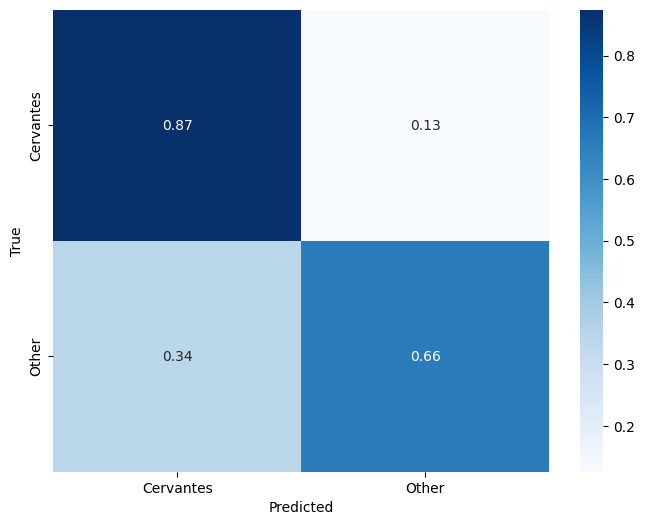

In [175]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test_frag, y_pred_fragments, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#### with majority vote

In [176]:
thresholds=list()

for threshold in np.arange(0.01, 0.9, 0.05):
    ensemble_preds, f1_score_ensemble = ensemble(predictions=predictions, y_test=y_test_frag, threshold=threshold, majority_vote=True)
    thresholds.append((f1_score_ensemble, threshold, np.sum(ensemble_preds)))

sorted(thresholds, reverse=True)

[(0.9074074074074074, 0.8600000000000001, 0),
 (0.9074074074074074, 0.81, 0),
 (0.9063352505468704, 0.76, 2),
 (0.9063352505468704, 0.7100000000000001, 2),
 (0.9063352505468704, 0.66, 2),
 (0.9063352505468704, 0.6100000000000001, 2),
 (0.8922385847920719, 0.56, 15),
 (0.8922385847920719, 0.51, 15),
 (0.8922385847920719, 0.46, 15),
 (0.8922385847920719, 0.41000000000000003, 15),
 (0.8578421986794487, 0.36000000000000004, 68),
 (0.8578421986794487, 0.31000000000000005, 68),
 (0.8578421986794487, 0.26, 68),
 (0.8578421986794487, 0.21000000000000002, 68),
 (0.7606052620738326, 0.16000000000000003, 159),
 (0.7606052620738326, 0.11, 159),
 (0.7606052620738326, 0.060000000000000005, 159),
 (0.7606052620738326, 0.01, 159)]

In [177]:
len(y_test_frag)

708

In [178]:
ensemble_preds, f1_score_ensemble = ensemble(predictions=predictions, y_test=y_test_frag, threshold=0.21, majority_vote=True)
                                            
print(classification_report(y_test_frag, ensemble_preds))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       588
           1       0.54      0.31      0.39       120

    accuracy                           0.84       708
   macro avg       0.71      0.63      0.65       708
weighted avg       0.82      0.84      0.82       708



In [179]:
res_df.loc[idx_res] = {'Grid':1,
                'Ensemble': 1,
                'Stacked': 0,
                'Pipeline': 1, 
                'With_proba': 0,
                'Weighted': 0, 
                'Whole_docs': 0,
                'F1_weighted': round(f1_score_ensemble, 2)
}
idx_res+=1
res_df.shape

(19, 8)

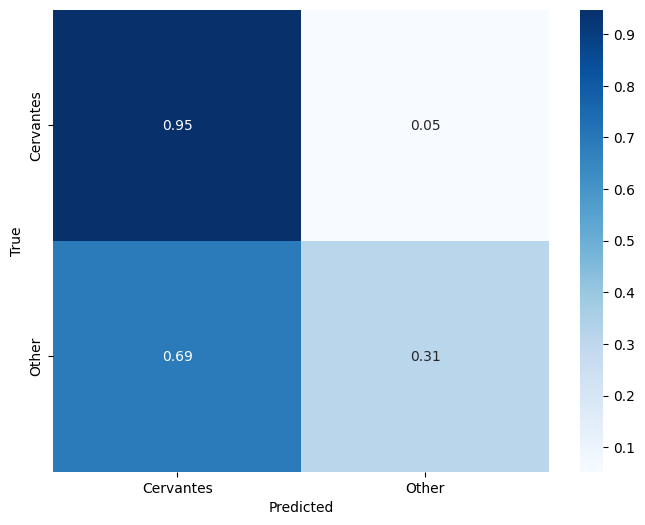

In [180]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test_frag, ensemble_preds, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

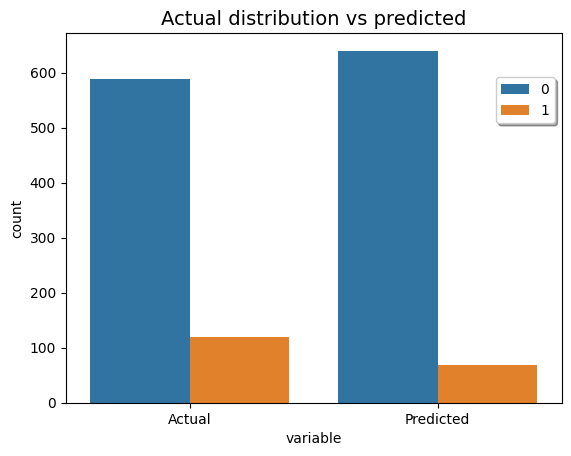

In [181]:
df_res = pd.DataFrame({'Actual': y_test_frag, 'Predicted': ensemble_preds})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

#### with weighting

In [182]:
thresholds=list()

for threshold in np.arange(0.01, 0.9, 0.05):
    ensemble_preds, f1_score_ensemble = ensemble(predictions=predictions, y_test=y_test_frag, threshold=threshold)
    thresholds.append((f1_score_ensemble, threshold, np.sum(ensemble_preds)))
    # print('Threshold:', threshold, 'f1:', f1_score_ensemble)
    # print(np.unique(ensemble_preds, return_counts=True))
    # print()
sorted(thresholds, reverse=True)

[(0.9074074074074074, 0.8600000000000001, 0),
 (0.9074074074074074, 0.81, 0),
 (0.9074074074074074, 0.76, 0),
 (0.9074074074074074, 0.7100000000000001, 0),
 (0.9074074074074074, 0.66, 0),
 (0.9063352505468704, 0.6100000000000001, 2),
 (0.9063352505468704, 0.56, 2),
 (0.9063352505468704, 0.51, 2),
 (0.8922385847920719, 0.46, 15),
 (0.8922385847920719, 0.41000000000000003, 15),
 (0.8922385847920719, 0.36000000000000004, 15),
 (0.8743177247917264, 0.31000000000000005, 57),
 (0.8578421986794487, 0.26, 68),
 (0.8578421986794487, 0.21000000000000002, 68),
 (0.8473772082879448, 0.16000000000000003, 86),
 (0.7606052620738326, 0.11, 159),
 (0.7606052620738326, 0.060000000000000005, 159),
 (0.7606052620738326, 0.01, 159)]

In [183]:
ensemble_preds, f1_score_ensemble = ensemble(predictions=predictions, y_test=y_test_frag, threshold=0.21)
f1_score_ensemble

0.8578421986794487

In [184]:
print(classification_report(y_test_frag, ensemble_preds))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       588
           1       0.54      0.31      0.39       120

    accuracy                           0.84       708
   macro avg       0.71      0.63      0.65       708
weighted avg       0.82      0.84      0.82       708



In [185]:
res_df.loc[idx_res] = {'Grid':1,
                'Ensemble': 1,
                'Stacked': 0,
                'Pipeline': 1, 
                'With_proba': 0,
                'Weighted': 1, 
                'Whole_docs': 0,
                'F1_weighted': round(f1_score_ensemble, 2)
}
idx_res+=1
res_df.shape

(20, 8)

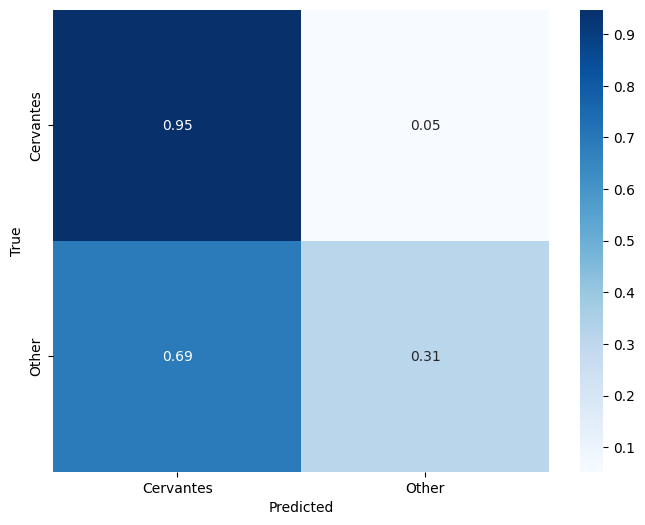

In [186]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test_frag, ensemble_preds, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

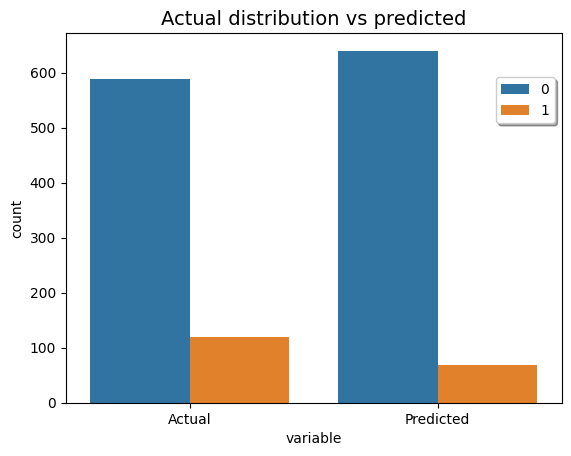

In [187]:
df_res = pd.DataFrame({'Actual': y_test_frag, 'Predicted': ensemble_preds})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

#### with probabilities

In [188]:
for i in np.arange(0.1, 1, 0.1):
    class_report, y_pred, f1_score_ensemble = ensamble_prob(probabilities_test, y_test_frag, threshold=i)
    print('threshold:', round(i,2), 'f1:', round(f1_score_ensemble,3), 'Positive preds:', sum(y_pred))

threshold: 0.1 f1: 0.358 Positive preds: 563
threshold: 0.2 f1: 0.693 Positive preds: 284
threshold: 0.3 f1: 0.838 Positive preds: 124
threshold: 0.4 f1: 0.885 Positive preds: 45
threshold: 0.5 f1: 0.9 Positive preds: 10
threshold: 0.6 f1: 0.907 Positive preds: 0
threshold: 0.7 f1: 0.907 Positive preds: 0
threshold: 0.8 f1: 0.907 Positive preds: 0
threshold: 0.9 f1: 0.907 Positive preds: 0


In [189]:
class_repo, y_pred,f1_score_ensemble = ensamble_prob(probabilities_test, y_test_frag, threshold=0.4)
print(class_repo)

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       588
           1       0.71      0.27      0.39       120

    accuracy                           0.86       708
   macro avg       0.79      0.62      0.65       708
weighted avg       0.84      0.86      0.83       708



In [190]:
res_df.loc[idx_res] = {'Grid':1,
                'Ensemble': 1,
                'Stacked': 0,
                'Pipeline': 1, 
                'With_proba': 1,
                'Weighted': 0, 
                'Whole_docs': 0,
                'F1_weighted': round(f1_score_ensemble, 2)
}
idx_res+=1
res_df.shape

(21, 8)

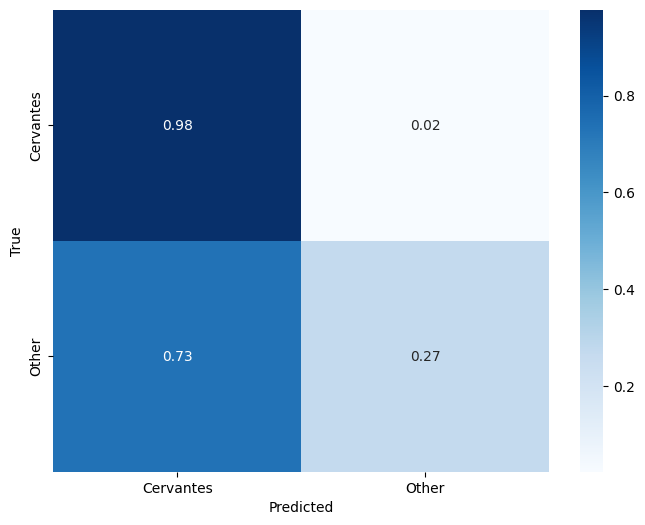

In [191]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test_frag, y_pred, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

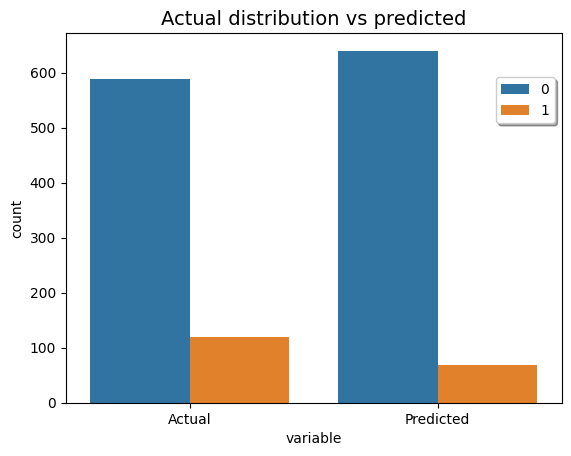

In [192]:
df_res = pd.DataFrame({'Actual': y_test_frag, 'Predicted': ensemble_preds})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

#### with weighted probability

In [193]:
res_lst = list()
for threshold in np.arange(0.11, 0.29, 0.01):
    for single_threshold in np.arange(0.21, 0.39, 0.01):
        class_report, y_pred,f1_score_ensemble = ensamble_prob_weighted(probabilities_test, y_test_frag, single_threshold=single_threshold, threshold=threshold)
        positive_class_f1 = (class_report.split('\n')[3].split()[3])
        if float(positive_class_f1) > 0:
            res_lst.append((round(f1_score_ensemble,2), round(float(positive_class_f1),2),(threshold, single_threshold), sum(y_pred)))
sorted(res_lst, reverse=True)[:10]

[(0.81, 0.53, (0.2799999999999999, 0.3700000000000001), 157),
 (0.81, 0.53, (0.2699999999999999, 0.3700000000000001), 157),
 (0.81, 0.53, (0.2599999999999999, 0.3700000000000001), 157),
 (0.81, 0.53, (0.24999999999999994, 0.3700000000000001), 157),
 (0.81, 0.53, (0.23999999999999994, 0.3700000000000001), 157),
 (0.81, 0.53, (0.22999999999999993, 0.3700000000000001), 157),
 (0.81, 0.53, (0.21999999999999995, 0.3700000000000001), 157),
 (0.81, 0.53, (0.20999999999999996, 0.3700000000000001), 157),
 (0.81, 0.53, (0.19999999999999996, 0.3700000000000001), 157),
 (0.81, 0.53, (0.18999999999999995, 0.3700000000000001), 157)]

In [194]:
class_report, y_pred,f1_score_ensemble = ensamble_prob_weighted(probabilities_test, y_test_frag, threshold=0.17, single_threshold=0.35) 
print(np.sum(y_pred))
print(class_report)

174
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       588
           1       0.43      0.62      0.51       120

    accuracy                           0.80       708
   macro avg       0.67      0.73      0.69       708
weighted avg       0.83      0.80      0.81       708



In [195]:
res_df.loc[idx_res] = {'Grid':1,
                'Ensemble': 1,
                'Stacked': 0,
                'Pipeline': 1, 
                'With_proba': 1,
                'Weighted': 1, 
                'Whole_docs': 0,
                'F1_weighted': round(f1_score_ensemble, 2)
}
idx_res+=1
res_df.shape

(22, 8)

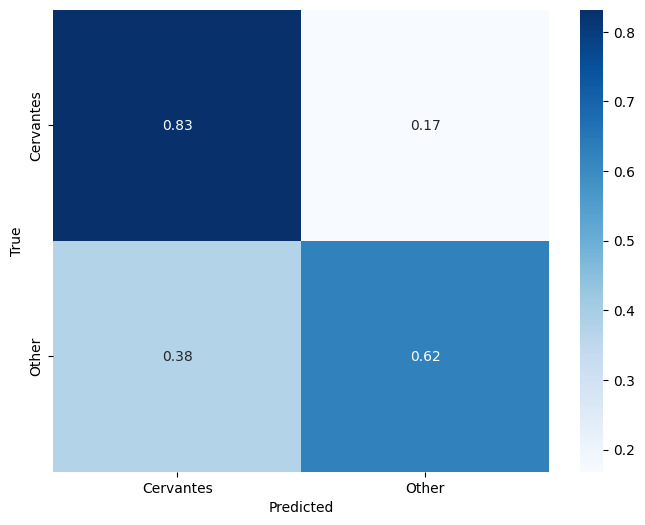

In [196]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test_frag, y_pred, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

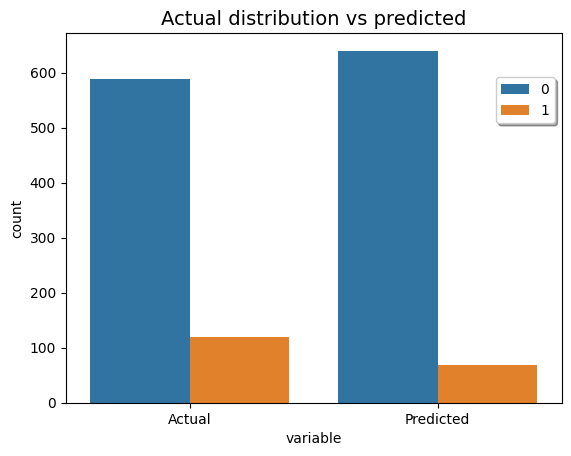

In [197]:
df_res = pd.DataFrame({'Actual': y_test_frag, 'Predicted': ensemble_preds})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

# Classification with one classifier

In [198]:
X_dev = hstacked_features
X_test = hstacked_features_test

In [199]:
X_test_fragments = hstacked_features_test_frag

In [200]:
# from sklearn.svm import SVC
# clf = SVC(random_state=42, class_weight='balanced')
# scores = cross_val_score(clf, X_dev, y_dev, cv=5, groups=groups_dev, scoring='f1_weighted')
# scores.mean(), scores.std()

In [201]:
clf = LinearSVC(random_state=42, dual='auto', class_weight='balanced', max_iter=10000000)
scores = cross_val_score(clf, X_dev, y_dev, cv=5, scoring='f1_weighted', groups=groups_dev)
scores.mean(), scores.std()
#(0.7462415184175024, 0.08596639814090719)

(0.7995990254159561, 0.07191272532116126)

In [202]:
clf = LinearSVC(random_state=42, dual='auto', class_weight='balanced', max_iter=10000000)
clf.fit(X_dev, y_dev)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print('Results on whole documents:') 
print('Accuracy (on whole documents):', acc) 
print('Weighted f1:',f1)
print()

y_pred_fragments = clf.predict(X_test_fragments)
acc = accuracy_score(y_test_frag, y_pred_fragments)
f1_frag = f1_score(y_test_frag, y_pred_fragments, average='weighted')
print('Results on whole fragments:') 
print('Accuracy:', acc) 
print('Weighted f1:',f1_frag)


Results on whole documents:
Accuracy (on whole documents): 1.0
Weighted f1: 1.0

Results on whole fragments:
Accuracy: 0.8516949152542372
Weighted f1: 0.8570798268604185


### whole docs

In [203]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [204]:
res_df.loc[idx_res] = {'Grid':0,
                'Ensemble': 0,
                'Stacked': 0,
                'Pipeline': 0, 
                'With_proba': 0,
                'Weighted': 0, 
                'Whole_docs': 1,
                'F1_weighted': round(f1, 2)
}
idx_res+=1
res_df.shape

(23, 8)

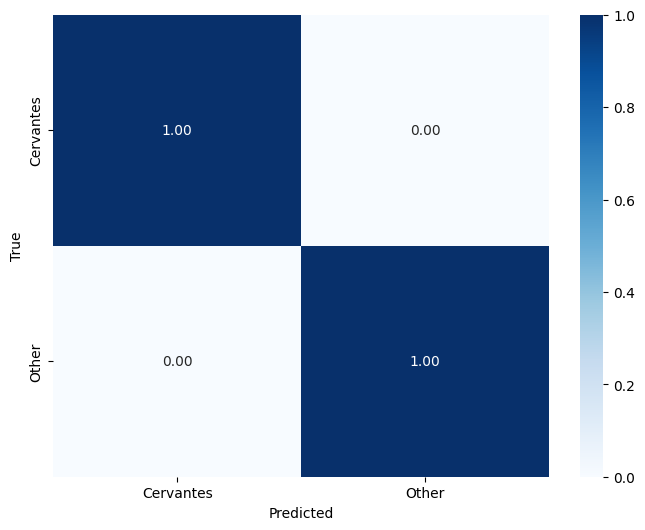

In [205]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### fragmented docs

In [206]:
print(classification_report(y_test_frag, y_pred_fragments))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       588
           1       0.55      0.67      0.60       120

    accuracy                           0.85       708
   macro avg       0.74      0.78      0.76       708
weighted avg       0.87      0.85      0.86       708



In [207]:
res_df.loc[idx_res] = {'Grid':0,
                'Ensemble': 0,
                'Stacked': 0,
                'Pipeline': 0, 
                'With_proba': 0,
                'Weighted': 0, 
                'Whole_docs': 0,
                'F1_weighted': round(f1_frag, 2)
}
idx_res+=1
res_df.shape

(24, 8)

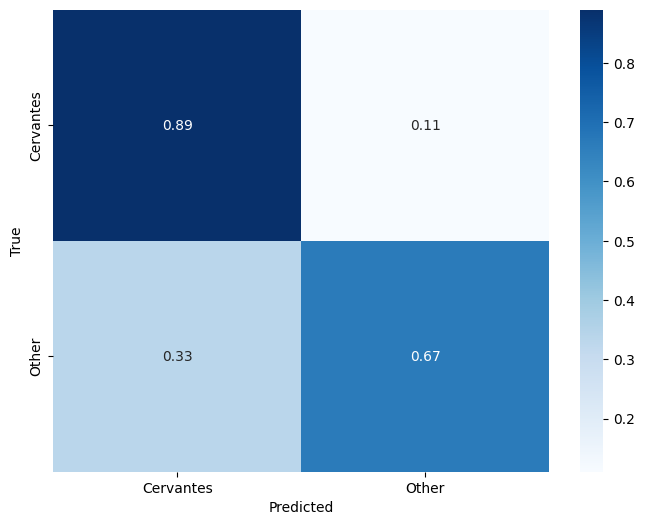

In [208]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test_frag, y_pred_fragments, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Grid search

In [209]:
clf = LinearSVC(random_state=42, dual='auto', class_weight='balanced', max_iter=10000000)   
#group_kfold = GroupKFold(n_splits=5)

param_grid= {'C': [0.1, 1, 10, 100,], #1, 10, 100, 200
             'dual': ['auto'],
             'random_state': [42]}

grid = GridSearchCV(
            clf,
            param_grid=param_grid,
            cv=5,
            n_jobs=-1,
            scoring='f1_weighted')

grid.fit(X_dev, y_dev, groups=groups_dev)
grid.best_estimator_, grid.best_score_

(LinearSVC(C=100, class_weight='balanced', dual='auto', max_iter=10000000,
           random_state=42),
 0.8152565726487998)

In [210]:
clf = grid.best_estimator_
clf.fit(X_dev, y_dev)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print('Results on whole documents:') 
print('Accuracy (on whole documents):', acc) 
print('Weighted f1:',f1)
print()

y_pred_fragments = clf.predict(X_test_fragments)
acc = accuracy_score(y_test_frag, y_pred_fragments)
f1_frag = f1_score(y_test_frag, y_pred_fragments, average='weighted')
print('Results on whole fragments:') 
print('Accuracy:', acc) 
print('Weighted f1:',f1)

Results on whole documents:
Accuracy (on whole documents): 1.0
Weighted f1: 1.0

Results on whole fragments:
Accuracy: 0.8813559322033898
Weighted f1: 1.0


### whole docs

In [211]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [212]:
res_df.loc[idx_res] = {'Grid':1,
                'Ensemble': 0,
                'Stacked': 0,
                'Pipeline': 0, 
                'With_proba': 0,
                'Weighted': 0, 
                'Whole_docs': 1,
                'F1_weighted': round(f1, 2)
}
idx_res+=1
res_df.shape

(25, 8)

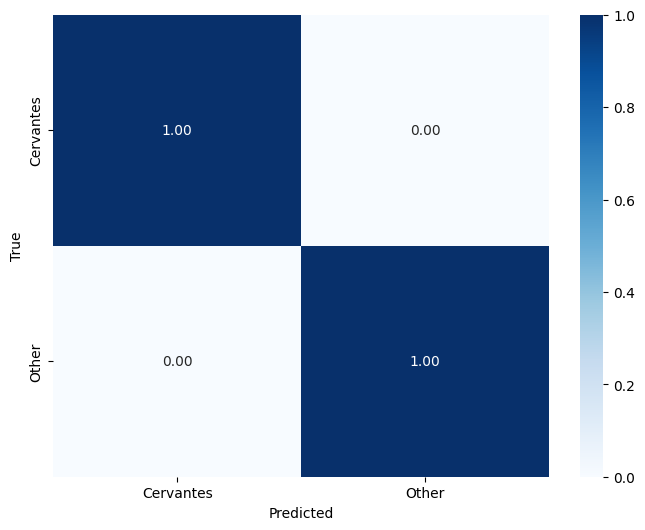

In [213]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

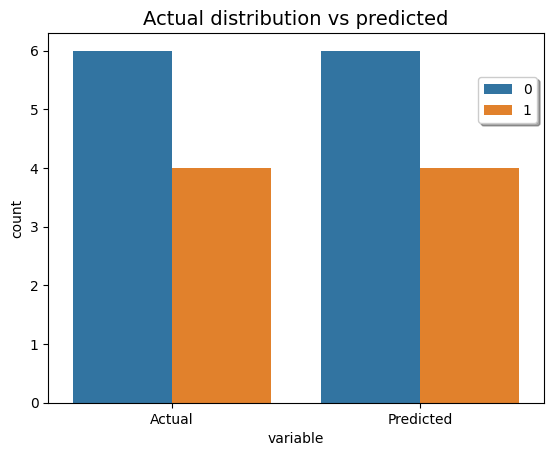

In [214]:
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

### fragmented docs

In [215]:
print(classification_report(y_test_frag, y_pred_fragments))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       588
           1       0.62      0.76      0.68       120

    accuracy                           0.88       708
   macro avg       0.79      0.83      0.81       708
weighted avg       0.89      0.88      0.89       708



In [216]:
res_df.loc[idx_res] = {'Grid':1,
                'Ensemble': 0,
                'Stacked': 0,
                'Pipeline': 0, 
                'With_proba': 0,
                'Weighted': 0, 
                'Whole_docs': 0,
                'F1_weighted': round(f1_frag, 2)
}
idx_res+=1
res_df.shape

(26, 8)

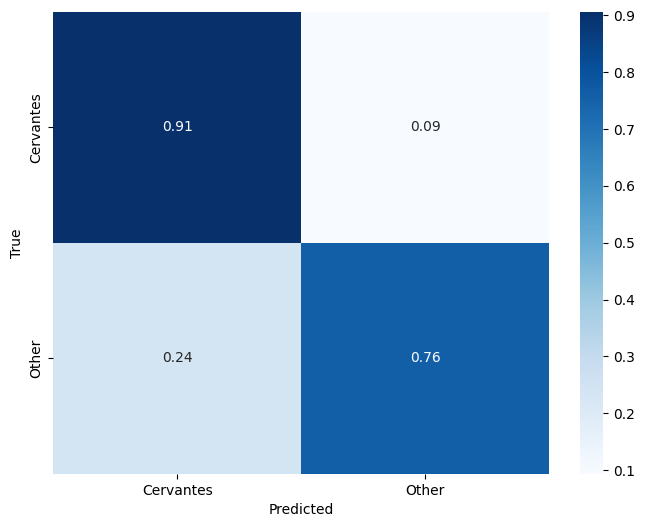

In [217]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test_frag, y_pred_fragments, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

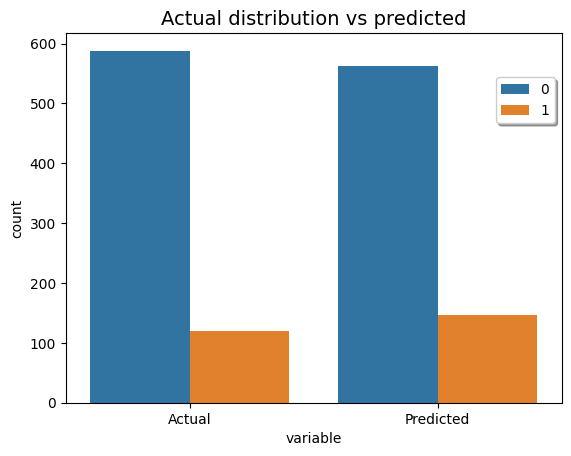

In [218]:
df_res = pd.DataFrame({'Actual': y_test_frag, 'Predicted': y_pred_fragments})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

# Model Evaluation

In [219]:
confidence_scores = clf.decision_function(X_test)
print('Confidence Scores:')
for score, pred, true in zip(confidence_scores, y_pred, y_test):
    print(score, pred, true)

Confidence Scores:
-1.7492837631229152 0 0
1.0837938842380028 1 1
-1.8147576276639588 0 0
-1.9558011811891238 0 0
0.969184859003172 1 1
-1.0002612614833808 0 0
-2.912433178171047 0 0
0.9303938561094514 1 1
0.5634718050795522 1 1
-1.0616532180796883 0 0


In [220]:
clf = CalibratedClassifierCV(clf) 
clf.fit(X_dev, y_dev)
y_proba = clf.predict_proba(X_test)

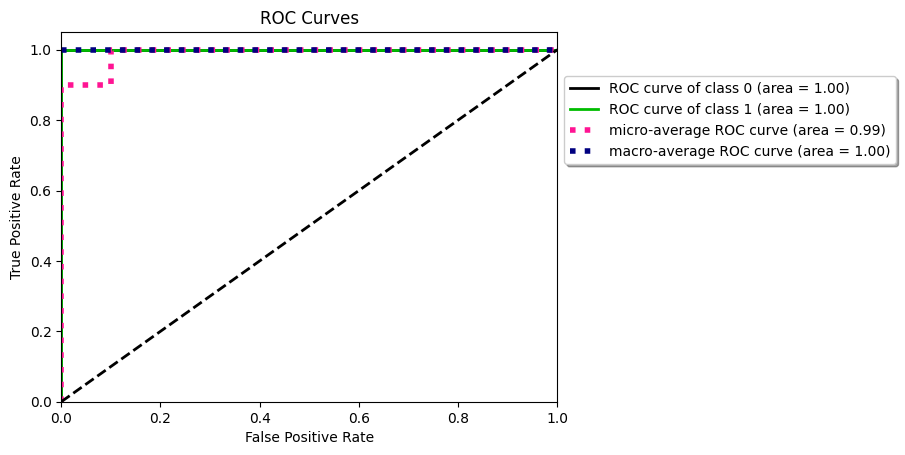

In [221]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()
#print(roc_auc_score(y_test, y_proba))

In [222]:
clf = CalibratedClassifierCV(clf) 
clf.fit(X_dev, y_dev)
y_proba = clf.predict_proba(X_test)

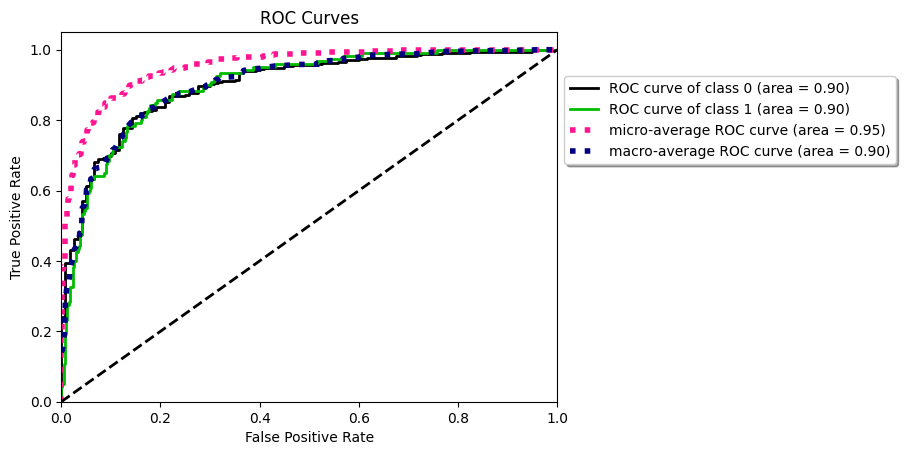

In [223]:
plot_roc(y_test_frag, clf.predict_proba(X_test_fragments))
plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

In [224]:
res_df[res_df['Whole_docs']==0].sort_values(by='F1_weighted', ascending=False)

,Grid,Ensemble,Stacked,Pipeline,With_proba,Weighted,Whole_docs,F1_weighted
11,1,1,0,0,1,1,0,0.91
20,1,1,0,1,1,0,0,0.89
25,1,0,0,0,0,0,0,0.89
8,1,1,0,0,0,0,0,0.86
9,1,1,0,0,0,1,0,0.86
10,1,1,0,0,1,0,0,0.86
18,1,1,0,1,0,0,0,0.86
19,1,1,0,1,0,1,0,0.86
23,0,0,0,0,0,0,0,0.86
7,1,1,1,0,0,0,0,0.85


In [225]:
res_df[res_df['Whole_docs']==1].sort_values(by='F1_weighted', ascending=False)

,Grid,Ensemble,Stacked,Pipeline,With_proba,Weighted,Whole_docs,F1_weighted
0,0,1,1,0,0,0,1,1.00
1,1,1,1,0,0,0,1,1.00
4,1,1,0,0,1,0,1,1.00
12,1,1,1,1,0,0,1,1.00
15,1,1,0,1,1,0,1,1.00
16,1,1,0,1,1,1,1,1.00
22,0,0,0,0,0,0,1,1.00
24,1,0,0,0,0,0,1,1.00
2,1,1,0,0,0,0,1,0.82
3,1,1,0,0,0,1,1,0.82


In [226]:
res_df[res_df['Stacked']==1].sort_values(by='F1_weighted', ascending=False)

,Grid,Ensemble,Stacked,Pipeline,With_proba,Weighted,Whole_docs,F1_weighted
0,0,1,1,0,0,0,1,1.00
1,1,1,1,0,0,0,1,1.00
12,1,1,1,1,0,0,1,1.00
7,1,1,1,0,0,0,0,0.85
17,1,1,1,1,0,0,0,0.85
6,0,1,1,0,0,0,0,0.84
